In [33]:
import glob

import matplotlib.pyplot as plt
import numpy as np
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat
import sys
sys.path.append(os.path.abspath('../../Code/Software/CarDpy-master'))
from cardpy.Sample_Data.Data_Paths import *
from cardpy.Data_Import            import *
from cardpy.Data_Sorting           import *
from cardpy.Data_Processing.DTI    import *
from cardpy.GUI_Tools              import IntERCOMS
from cardpy.Colormaps              import *
from cardpy.Data_Saving            import *
from cardpy.Data_Processing.cDTI   import *
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import nrrd

cDTI_cmaps     = cDTI_Colormaps_Generator()



import seaborn as sns
sns.set(style='darkgrid', palette='Set2')




In [34]:
sys.path.append(os.path.abspath('../../Code/Software/'))
def myocardial_mask_contour_filler(myocardial_mask, endocardial_cordinates, epicardial_cordinates):
    import cv2
    import numpy as np
    from cDTIpy.Diffusion.cDTI import point2pixel
    
    new_endocardial_x   = []
    new_endocardial_y   = []
    new_epicardial_x    = []
    new_epicardial_y    = []
    rows                = myocardial_mask.shape[0]
    columns             = myocardial_mask.shape[1]
    endocardial_contour = np.zeros([rows, columns])
    for index in range(endocardial_cordinates[0].shape[0]):
        [new_x_coordinate, new_y_coordinate] = point2pixel(epicardial_cordinates[0][index],  epicardial_cordinates[1][index])
        new_epicardial_x.append(new_x_coordinate)
        new_epicardial_y.append(new_y_coordinate)
        [new_x_coordinate, new_y_coordinate] = point2pixel(endocardial_cordinates[0][index], endocardial_cordinates[1][index])
        new_endocardial_x.append(new_x_coordinate)
        new_endocardial_y.append(new_y_coordinate)

    new_endocardium_points = [np.array(new_endocardial_x), np.array(new_endocardial_y)]
    new_epicardium_points  = [np.array(new_epicardial_x),  np.array(new_epicardial_y)]

    endocardial_points = np.hstack((new_endocardium_points[0][:, np.newaxis], new_endocardium_points[1][:, np.newaxis]))
    epicardial_points  = np.hstack((new_epicardium_points[0][:, np.newaxis],  new_epicardium_points[1][:, np.newaxis]))
    temp_matrix        = np.zeros([rows, columns])
    endocardial_mask   = cv2.fillPoly(temp_matrix, np.int32([endocardial_points]), color=(255,255,255))
    endocardial_mask   = endocardial_mask / 255
    temp_matrix        = np.zeros([rows, columns])
    epicardial_mask    = cv2.fillPoly(temp_matrix, np.int32([epicardial_points]),  color=(255,255,255))
    epicardial_mask    = epicardial_mask / 255
    
    for index in range(endocardial_points.shape[0]):
        x                         = endocardial_points[index, 0]
        y                         = endocardial_points[index, 1]
        endocardial_contour[y, x] = 1
    filled_myocardial_mask = epicardial_mask - endocardial_mask + endocardial_contour
    return filled_myocardial_mask

def point2pixel(x_coordinate, y_coordinate):
    import numpy as np
    import math
    point_x = x_coordinate
    point_y = y_coordinate
    
    floor_x = np.floor(point_x)
    floor_y = np.floor(point_y)
    ceil_x  = np.ceil(point_x)
    ceil_y  = np.ceil(point_y)
    
    point  = np.array([point_x, point_y])
    quad_1 = np.array([ceil_x,  floor_y])
    quad_2 = np.array([ceil_x,  ceil_y])
    quad_3 = np.array([floor_x, ceil_y])
    quad_4 = np.array([floor_x, floor_y])
    
    quadrant_list = [np.array([ceil_x,  floor_y]), np.array([ceil_x,  ceil_y]), np.array([floor_x, ceil_y]), np.array([floor_x, floor_y])]
    distance_list = []
    for quadrant in range(len(quadrant_list)):
        distance_list.append(math.dist(point, quadrant_list[quadrant]))
    
    quadrant_index = distance_list.index(min(distance_list))
    new_x_coordinate = int(quadrant_list[quadrant_index][0])
    new_y_coordinate = int(quadrant_list[quadrant_index][1])
    return[new_x_coordinate, new_y_coordinate]
    
def myocardial_contour_extraction(mask, slice_number):
    import numpy as np
    import skimage
    from   cDTIpy.Diffusion.cDTI import comprehensive_inner_contour, comprehensive_outter_contour

    rows = mask.shape[0]
    cols = mask.shape[1]
    slc  = slice_number
    Background_Mask = np.zeros([rows, cols])
    Myocardial_Mask = np.zeros([rows, cols])
    Blood_Pool_Mask = np.zeros([rows, cols])
    Endocardial_Centers  = []
    Epicardium_Contours  = []
    Endocardium_Contours = []
    Background_temp = np .zeros([rows, cols])
    Myocardium_temp = np .zeros([rows, cols])
    Blood_Pool_temp = np .zeros([rows, cols])
    Mask_Label = skimage.measure.label(abs(mask[:, :, slc] - 1),
                                       background = None,
                                       return_num = False,
                                       connectivity = 1)
     
    Background_temp[Mask_Label == 1] = 1
    Myocardium_temp[Mask_Label == 0] = 1
    Blood_Pool_temp[Mask_Label == 2] = 1
    
    Background_Mask = Background_temp
    Myocardial_Mask = Myocardium_temp
    Blood_Pool_Mask = Blood_Pool_temp
    
    [x_coordinates_endo,  y_coordinates_endo] = np.where(Blood_Pool_temp == 1)
    mean_y_coordinates_endo  = np.int64(np.round(np.mean(y_coordinates_endo)))
    mean_x_coordinates_endo  = np.int64(np.round(np.mean(x_coordinates_endo)))
    Endocardial_Centers.append([mean_x_coordinates_endo, mean_y_coordinates_endo])
    
    epicardium_contour  = comprehensive_outter_contour(Myocardial_Mask)
    endocardium_contour = comprehensive_inner_contour(Myocardial_Mask,
                                                      np.int64(Endocardial_Centers[0][0]),
                                                      np.int64(Endocardial_Centers[0][1]))
    endocardium_contour = endocardium_contour - (endocardium_contour * epicardium_contour)
    Epicardium_Contours.append(epicardium_contour)
    Endocardium_Contours.append(endocardium_contour)
    
    return [Epicardium_Contours, Endocardium_Contours, Endocardial_Centers]
    
def comprehensive_inner_contour(mask, offset_x, offset_y):
    import numpy as np
    rows = mask.shape[0]
    cols = mask.shape[1]

    pos_x_pos_y = np.zeros([rows, cols])
    pos_x_pos_y = np.zeros([rows, cols])
    for x in range(rows - offset_x):
        stop_flag = 'OFF'
        if mask[x + offset_x, 0 + offset_y] == 1:
            stop_flag = 'ON'
        for y in range(cols - offset_y):
            if stop_flag == 'OFF':
                if mask[x + offset_x, y + offset_y] == 0:
                    pos_x_pos_y[x + offset_x, y + offset_y] = 0
                if mask[x + offset_x, y + offset_y] == 1:
                    pos_x_pos_y[x + offset_x, y + offset_y] = 1
                    stop_flag = 'ON'
            if stop_flag == 'ON':
                break
    pos_x_neg_y = np.zeros([rows, cols])
    for x in range(rows - offset_x):
        stop_flag = 'OFF'
        if mask[x + offset_x, offset_y - 0] == 1:
            stop_flag = 'ON'
        for y in range(offset_y + 1):
            if stop_flag == 'OFF':
                if mask[x + offset_x, offset_y - y] == 0:
                    pos_x_neg_y[x + offset_x, offset_y - y] = 0
                if mask[x + offset_x, offset_y - y] == 1:
                    pos_x_neg_y[x + offset_x, offset_y - y] = 1
                    stop_flag = 'ON'
            if stop_flag == 'ON':
                break
    neg_x_neg_y = np.zeros([rows, cols])
    for x in range(offset_x + 1):
        stop_flag = 'OFF'
        if mask[offset_x - x, offset_y - 0] == 1:
            stop_flag = 'ON'
        for y in range(offset_y + 1):
            if stop_flag == 'OFF':
                if mask[offset_x - x, offset_y - y] == 0:
                    neg_x_neg_y[offset_x - x, offset_y - y] = 0
                if mask[offset_x - x, offset_y - y] == 1:
                    neg_x_neg_y[offset_x - x, offset_y - y] = 1
                    stop_flag = 'ON'
            if stop_flag == 'ON':
                break
    neg_x_pos_y = np.zeros([rows, cols])
    for x in range(offset_x + 1):
        stop_flag = 'OFF'
        if mask[offset_x - x, 0 + offset_y] == 1:
            stop_flag = 'ON'
        for y in range(cols - offset_y):
            if stop_flag == 'OFF':
                if mask[offset_x - x, y + offset_y] == 0:
                    neg_x_pos_y[offset_x - x, y + offset_y] = 0
                if mask[offset_x - x, y + offset_y] == 1:
                    neg_x_pos_y[offset_x - x, y + offset_y] = 1
                    stop_flag = 'ON'
            if stop_flag == 'ON':
                break
    ###
    pos_y_pos_x = np.zeros([rows, cols])
    for y in range(cols - offset_y):
        stop_flag = 'OFF'
        if mask[0 + offset_x, y + offset_y] == 1:
            stop_flag = 'ON'
        for x in range(rows - offset_x):
            if stop_flag == 'OFF':
                if mask[x + offset_x, y + offset_y] == 0:
                    pos_y_pos_x[x + offset_x, y + offset_y] = 0
                if mask[x + offset_x, y + offset_y] == 1:
                    pos_y_pos_x[x + offset_x, y + offset_y] = 1
                    stop_flag = 'ON'
            if stop_flag == 'ON':
                break
    neg_y_pos_x = np.zeros([rows, cols])
    for y in range(offset_y + 1):
        stop_flag = 'OFF'
        if mask[0 + offset_x, offset_y - y] == 1:
            stop_flag = 'ON'
        for x in range(rows - offset_x):
            if stop_flag == 'OFF':
                if mask[x + offset_x, offset_y - y] == 0:
                    neg_y_pos_x[x + offset_x, offset_y - y] = 0
                if mask[x + offset_x, offset_y - y] == 1:
                    neg_y_pos_x[x + offset_x, offset_y - y] = 1
                    stop_flag = 'ON'
            if stop_flag == 'ON':
                break
    neg_y_neg_x = np.zeros([rows, cols])
    for y in range(offset_y + 1):
        stop_flag = 'OFF'
        if mask[offset_x - 0, offset_y - y] == 1:
            stop_flag = 'ON'
        for x in range(offset_x + 1):
            if stop_flag == 'OFF':
                if mask[offset_x - x, offset_y - y] == 0:
                    neg_y_neg_x[offset_x - x, offset_y - y] = 0
                if mask[offset_x - x, offset_y - y] == 1:
                    neg_y_neg_x[offset_x - x, offset_y - y] = 1
                    stop_flag = 'ON'
            if stop_flag == 'ON':
                break
    pos_y_neg_x = np.zeros([rows, cols])
    for y in range(cols - offset_y):
        stop_flag = 'OFF'
        if mask[offset_x - 0, y + offset_y] == 1:
            stop_flag = 'ON'
        for x in range(offset_x + 1):
            if stop_flag == 'OFF':
                if mask[offset_x - x, y + offset_y] == 0:
                    pos_y_neg_x[offset_x - x, y + offset_y] = 0
                if mask[offset_x - x, y + offset_y] == 1:
                    pos_y_neg_x[offset_x - x, y + offset_y] = 1
                    stop_flag = 'ON'
            if stop_flag == 'ON':
                break

    x_all = pos_x_pos_y + pos_x_neg_y + neg_x_neg_y + neg_x_pos_y
    y_all = pos_y_pos_x + pos_y_neg_x + neg_y_neg_x + neg_y_pos_x
    contour = x_all + y_all
    contour[contour >= 1] = 1
    return contour

def comprehensive_outter_contour(mask):
    import numpy as np

    rows = mask.shape[0]
    cols = mask.shape[1]

    pos_x_pos_y = np.zeros([rows, cols])
    for x in range(rows):
        stop_flag = 'OFF'
        for y in range(cols):
            if stop_flag == 'OFF':
                if mask[x, y] == 0:
                    pos_x_pos_y[x, y] = 0
                if mask[x, y] == 1:
                    pos_x_pos_y[x, y] = 1
                    stop_flag = 'ON'
            if stop_flag == 'ON':
                break
    pos_x_neg_y = np.zeros([rows, cols])
    for x in range(rows):
        stop_flag = 'OFF'
        for y in range(cols):
            if stop_flag == 'OFF':
                if mask[x, cols - 1 - y] == 0:
                    pos_x_pos_y[x, cols - 1 - y] = 0
                if mask[x, cols - 1 - y] == 1:
                    pos_x_pos_y[x, cols - 1 - y] = 1
                    stop_flag = 'ON'
            if stop_flag == 'ON':
                break
    neg_x_neg_y = np.zeros([rows, cols])
    for x in range(rows):
        stop_flag = 'OFF'
        for y in range(cols):
            if stop_flag == 'OFF':
                if mask[rows - 1 - x, cols - 1 - y] == 0:
                    pos_x_pos_y[rows - 1 - x, cols - 1 - y] = 0
                if mask[rows - 1 - x, cols - 1 - y] == 1:
                    pos_x_pos_y[rows - 1 - x, cols - 1 - y] = 1
                    stop_flag = 'ON'
            if stop_flag == 'ON':
                break
    neg_x_pos_y = np.zeros([rows, cols])
    for x in range(rows):
        stop_flag = 'OFF'
        for y in range(cols):
            if stop_flag == 'OFF':
                if mask[rows - 1 - x, y] == 0:
                    pos_x_pos_y[rows - 1 - x, y] = 0
                if mask[rows - 1 - x, y] == 1:
                    pos_x_pos_y[rows - 1 - x, y] = 1
                    stop_flag = 'ON'
            if stop_flag == 'ON':
                break
    ###
    pos_y_pos_x = np.zeros([rows, cols])
    for y in range(cols):
        stop_flag = 'OFF'
        for x in range(rows):
            if stop_flag == 'OFF':
                if mask[x, y] == 0:
                    pos_y_pos_x[x, y] = 0
                if mask[x, y] == 1:
                    pos_y_pos_x[x, y] = 1
                    stop_flag = 'ON'
            if stop_flag == 'ON':
                break
    pos_y_neg_x = np.zeros([rows, cols])
    for y in range(cols):
        stop_flag = 'OFF'
        for x in range(rows):
            if stop_flag == 'OFF':
                if mask[rows - 1 - x, y] == 0:
                    pos_y_neg_x[rows - 1 - x, y] = 0
                if mask[rows - 1 - x, y] == 1:
                    pos_y_neg_x[rows - 1 - x, y] = 1
                    stop_flag = 'ON'
            if stop_flag == 'ON':
                break
    neg_y_neg_x = np.zeros([rows, cols])
    for y in range(cols):
        stop_flag = 'OFF'
        for x in range(rows):
            if stop_flag == 'OFF':
                if mask[rows - 1 - x, cols - 1 - y] == 0:
                    neg_y_neg_x[rows - 1 - x, cols - 1 - y] = 0
                if mask[rows - 1 - x, cols - 1 - y] == 1:
                    neg_y_neg_x[rows - 1 - x, cols - 1 - y] = 1
                    stop_flag = 'ON'
            if stop_flag == 'ON':
                break
    neg_y_pos_x = np.zeros([rows, cols])
    for y in range(cols):
        stop_flag = 'OFF'
        for x in range(rows):
            if stop_flag == 'OFF':
                if mask[x, cols - 1 - y] == 0:
                    neg_y_pos_x[x, cols - 1 - y] = 0
                if mask[x, cols - 1 - y] == 1:
                    neg_y_pos_x[x, cols - 1 - y] = 1
                    stop_flag = 'ON'
            if stop_flag == 'ON':
                break
    x_all = pos_x_pos_y + pos_x_neg_y + neg_x_neg_y + neg_x_pos_y
    y_all = pos_y_pos_x + pos_y_neg_x + neg_y_neg_x + neg_y_pos_x
    contour = x_all + y_all
    contour[contour >= 1] = 1
    return contour


In [35]:
def Endo2Epi_grid(LV_Mask):
    import skimage
    import numpy as np
    from scipy.interpolate import griddata

    rows    = LV_Mask.shape[0]
    columns = LV_Mask.shape[1]
    slices  = LV_Mask.shape[2]
    grid    = np.zeros([rows, columns, slices])

    for slc in range(slices):

        tmp_mask = np.ones([rows, columns]) - LV_Mask[:, :, slc]
        labels = skimage.measure.label(tmp_mask, connectivity = 1, background = 0, return_num = True)

        Epi_Outside = np.zeros([rows, columns])
        Endo_inside = np.zeros([rows, columns])

        Epi_Outside[labels[0] == 1] = 1
        Endo_inside[labels[0] == 2] = 1

        [epi_x,  epi_y]             = np.where(Epi_Outside == 1)
        [endo_x, endo_y]            = np.where(Endo_inside == 1)
        epi  = np.stack((epi_y, epi_x), axis=1)
        endo  = np.stack((endo_y, endo_x), axis=1)
        points = np.vstack((epi,endo))

        epi_val  = np.ones((epi_x.shape[0], 1))
        endo_val = np.zeros((endo_x.shape[0], 1))    
        values   = np.vstack((epi_val,endo_val))

        x = np.linspace(0, rows - 1,    rows)
        y = np.linspace(0, columns - 1, columns)
        xi, yi = np.meshgrid(y, x)
        tmp_grid = np.squeeze(griddata(points, values, (xi, yi), method='cubic')) * LV_Mask[:, :, slc]
        grid[:, :, slc] = tmp_grid
    return grid

In [36]:
vox_folder = ['vol_2.0res_3.0sl','vol_2.0res_5.0sl','vol_2.0res_8.0sl',
            'vol_2.5res_3.0sl','vol_2.5res_5.0sl','vol_2.5res_8.0sl',
            'vol_3.0res_3.5sl','vol_3.0res_5.5sl','vol_3.0res_8.0sl']
            
vol_idx = ['V001','V002','V003','V004','V005','V006','V007','V008','V009','V010', 'V011']
volumes = [2*2*3,2*2*5,2*2*8,2.5*2.5*3,2.5*2.5*5,2.5*2.5*8,3*3*3.5,3*3*5.5,3*3*8]

In [37]:
from scipy.stats import gaussian_kde
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
r2_all = []
data_list = []
epi_end_slope = np.zeros([11,9])
epi_end_int = np.zeros([11,9])
test = np.zeros([11,9])
med_all = []

HAP_all = []

for ii in range(9):
    pitch =[]
    r2 = []
    for vv in range(11):
        #print(vol_idx[vv])
        main_path = os.path.join(os.path.abspath('../../Data/NifTi/'+vol_idx[vv]) + '/'+ vox_folder[ii] + '/ADC_Filtered')
        path_segmentation = os.path.join(os.path.abspath('../../Data/Segmentations/'+vol_idx[vv]),vox_folder[ii])
        path_maps  = os.path.join(os.path.abspath('../../Data/DTI_Maps/'+vol_idx[vv])+'/'+ vox_folder[ii] + '/ADC_Filtered')

        NifTi_path = glob.glob(os.path.join(main_path, '*Averaged', '*.nii'))[0]
        header_path              = glob.glob(os.path.join(main_path, '*Averaged', '*.header'))[0]
        b_values_path            = glob.glob(os.path.join(main_path, '*Averaged', '*.bvals'))[0]
        b_vectors_path           = glob.glob(os.path.join(main_path, '*Averaged', '*.bvecs'))[0]


        Seg_path    = os.path.join(path_segmentation)
        Maps_Folder = os.path.join(path_maps)

        
        [data, b_vals_stacked, b_vecs_stacked, Header, _, _] = NifTi_Reader(NifTi_path, b_values_path, b_vectors_path, header_path)
        myo_mask = loadmat(os.path.join(Seg_path,'Interpolated_mask.mat'))['Mask']
        myo_mask = myo_mask.astype('float')
        myo_mask[myo_mask == 0] = np.nan

        dim_x = data.shape[0]
        dim_y = data.shape[1]

        Cardiac_DTI_Metrics = loadmat(os.path.join(Maps_Folder, 'cDTI_Metrics.mat'))
        
        myo_mask.astype('float')
        myo_mask[myo_mask==0] = np.nan
        
        slc = 0
        tmp_mask = myo_mask
        tmp_mask = tmp_mask.astype('int')
        grid = Endo2Epi_grid(tmp_mask)
        grid_nan = np.copy(grid)
        grid_nan[grid == 0] = np.nan

        E2E_data = grid_nan[:, :, slc].flatten()
        E2E_map = grid_nan[:, :, slc]
        E2E_data = E2E_data[~(np.isnan(grid_nan[:, :, slc].flatten()))]
        x = E2E_data
        xi = np.copy(x)

        HA = Cardiac_DTI_Metrics['HA'][:, :, 0]
        HA_data  = HA.flatten()
        HA_data  = HA_data[~(np.isnan(grid_nan[:, :, 0].flatten()))]
        y = HA_data
        # remove nan from y numpy array
        idx = np.argwhere(np.isnan(y))
        y = y[~np.isnan(y)]
        yi = np.copy(y)

        # delete nan from x numpy array
        x = np.delete(x, idx)
        
        # Calculate the point density
        xy = np.vstack([x, y])

        z = gaussian_kde(xy)(xy)

        # Sort the points by density, so that the densest points are plotted last
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]
        density = plt.scatter(x, y, c=z, s=50, cmap = 'hot')
        model                 = LinearRegression().fit(x[:, np.newaxis], y[:, np.newaxis])
        HAP   = model.coef_[0][0] / 100

        epi_end_slope[vv,ii] = model.coef_[0,0]
        epi_end_int[vv,ii] = model.intercept_[0]
        
        pitch.append(HAP)

        model   = LinearRegression().fit(x[:, np.newaxis]*100, y[:, np.newaxis])
        xx = np.linspace(0, 1, 100)
        y_predicted = model.intercept_ + model.coef_ * xx[:, np.newaxis]
        test[vv,ii] = model.coef_[0,0]

        r2_score = model.score(x[:, np.newaxis]*100, y[:, np.newaxis])
        r2.append(r2_score)

        r2_scoreB = model.score(xx[:,np.newaxis], y_predicted)





        plt.close()

    HAP_all.append(pitch)
    
    med = np.median(pitch)
    sorted_data = np.sort(np.array(pitch))
    lower_index = int(0.025 * len(sorted_data))
    upper_index = int(0.975 * len(sorted_data))
    lb = sorted_data[lower_index]
    ub = sorted_data[upper_index]
    print(vox_folder[ii], 'HAP: Median {:.2f} and 95% CI [{:.2f},{:.2f}], R2 = {:.2f}'.format(med,lb,ub,np.nanmean(np.array(r2)))) #ub-lb
    med_all.append(med)
    r2_all.append(r2)

/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_10400/2454859228.py:47: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.astype('int')
/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_10400/2454859228.py:47: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.astype('int')
/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_10400/2454859228.py:47: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.astype('int')
/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_10400/2454859228.py:47: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.astype('int')
/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_10400/2454859228.py:47: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.astype('int')
/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_10400/2454859228.py:47: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.

vol_2.0res_3.0sl HAP: Median -0.58 and 95% CI [-0.80,-0.13], R2 = 0.18


/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_10400/2454859228.py:47: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.astype('int')
/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_10400/2454859228.py:47: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.astype('int')
/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_10400/2454859228.py:47: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.astype('int')
/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_10400/2454859228.py:47: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.astype('int')
/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_10400/2454859228.py:47: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.astype('int')
/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_10400/2454859228.py:47: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.

vol_2.0res_5.0sl HAP: Median -0.57 and 95% CI [-0.93,-0.48], R2 = 0.27


/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_10400/2454859228.py:47: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.astype('int')
/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_10400/2454859228.py:47: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.astype('int')
/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_10400/2454859228.py:47: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.astype('int')
/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_10400/2454859228.py:47: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.astype('int')
/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_10400/2454859228.py:47: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.astype('int')
/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_10400/2454859228.py:47: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.

vol_2.0res_8.0sl HAP: Median -0.67 and 95% CI [-0.89,-0.38], R2 = 0.30


/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_10400/2454859228.py:47: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.astype('int')
/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_10400/2454859228.py:47: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.astype('int')
/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_10400/2454859228.py:47: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.astype('int')
/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_10400/2454859228.py:47: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.astype('int')
/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_10400/2454859228.py:47: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.astype('int')
/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_10400/2454859228.py:47: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.

vol_2.5res_3.0sl HAP: Median -0.51 and 95% CI [-0.84,-0.33], R2 = 0.16


/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_10400/2454859228.py:47: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.astype('int')
/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_10400/2454859228.py:47: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.astype('int')
/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_10400/2454859228.py:47: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.astype('int')
/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_10400/2454859228.py:47: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.astype('int')
/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_10400/2454859228.py:47: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.astype('int')
/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_10400/2454859228.py:47: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.

vol_2.5res_5.0sl HAP: Median -0.71 and 95% CI [-0.83,-0.20], R2 = 0.23


/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_10400/2454859228.py:47: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.astype('int')
/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_10400/2454859228.py:47: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.astype('int')
/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_10400/2454859228.py:47: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.astype('int')
/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_10400/2454859228.py:47: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.astype('int')
/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_10400/2454859228.py:47: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.astype('int')
/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_10400/2454859228.py:47: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.

vol_2.5res_8.0sl HAP: Median -0.65 and 95% CI [-0.82,-0.25], R2 = 0.24


/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_10400/2454859228.py:47: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.astype('int')
/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_10400/2454859228.py:47: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.astype('int')
/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_10400/2454859228.py:47: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.astype('int')
/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_10400/2454859228.py:47: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.astype('int')
/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_10400/2454859228.py:47: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.astype('int')
/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_10400/2454859228.py:47: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.

vol_3.0res_3.5sl HAP: Median -0.56 and 95% CI [-1.03,-0.12], R2 = 0.17


/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_10400/2454859228.py:47: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.astype('int')
/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_10400/2454859228.py:47: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.astype('int')
/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_10400/2454859228.py:47: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.astype('int')
/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_10400/2454859228.py:47: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.astype('int')
/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_10400/2454859228.py:47: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.astype('int')
/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_10400/2454859228.py:47: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.

vol_3.0res_5.5sl HAP: Median -0.68 and 95% CI [-1.01,-0.26], R2 = 0.23


/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_10400/2454859228.py:47: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.astype('int')
/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_10400/2454859228.py:47: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.astype('int')
/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_10400/2454859228.py:47: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.astype('int')
/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_10400/2454859228.py:47: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.astype('int')
/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_10400/2454859228.py:47: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.astype('int')
/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_10400/2454859228.py:47: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.

vol_3.0res_8.0sl HAP: Median -0.52 and 95% CI [-1.02,-0.32], R2 = 0.16


/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_10400/2454859228.py:47: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.astype('int')


In [38]:
np.nanmean(np.array(r2_all),axis = 1)


array([0.18170553, 0.26894488, 0.30499344, 0.15927726, 0.22501334,
       0.23891743, 0.16604713, 0.23025721, 0.16300874])

# Report HAP as a Heatmap
Here we report the medians that are visualized in the boxplot as a Heatmap. The bolded value is the global median while the 95% confidence interval is in brackets

In [39]:
def Bootstrap_95_CI(data):
    data = np.array(data)
    N = data.shape[0]
    Nbs = 1000

    np.random.seed(0)
    bs_idx = np.random.randint(0, N, (N, Nbs))
    bs = data[bs_idx]

    lower_bound = np.percentile(bs, 2.5, axis=0).mean()
    upper_bound = np.percentile(bs, 97.5, axis=0).mean()
    CI_low = lower_bound
    CI_high = upper_bound
    return [CI_low, CI_high]


HAP_adjust = np.array(HAP_all).T
print(HAP_adjust.shape)
lb = []
ub =  []
for ii in range(9):
    lb_tmp,ub_tmp  = Bootstrap_95_CI(HAP_adjust[:,ii])   
    lb.append(lb_tmp)
    ub.append(ub_tmp)

HAP_adjust.shape


(11, 9)


(11, 9)

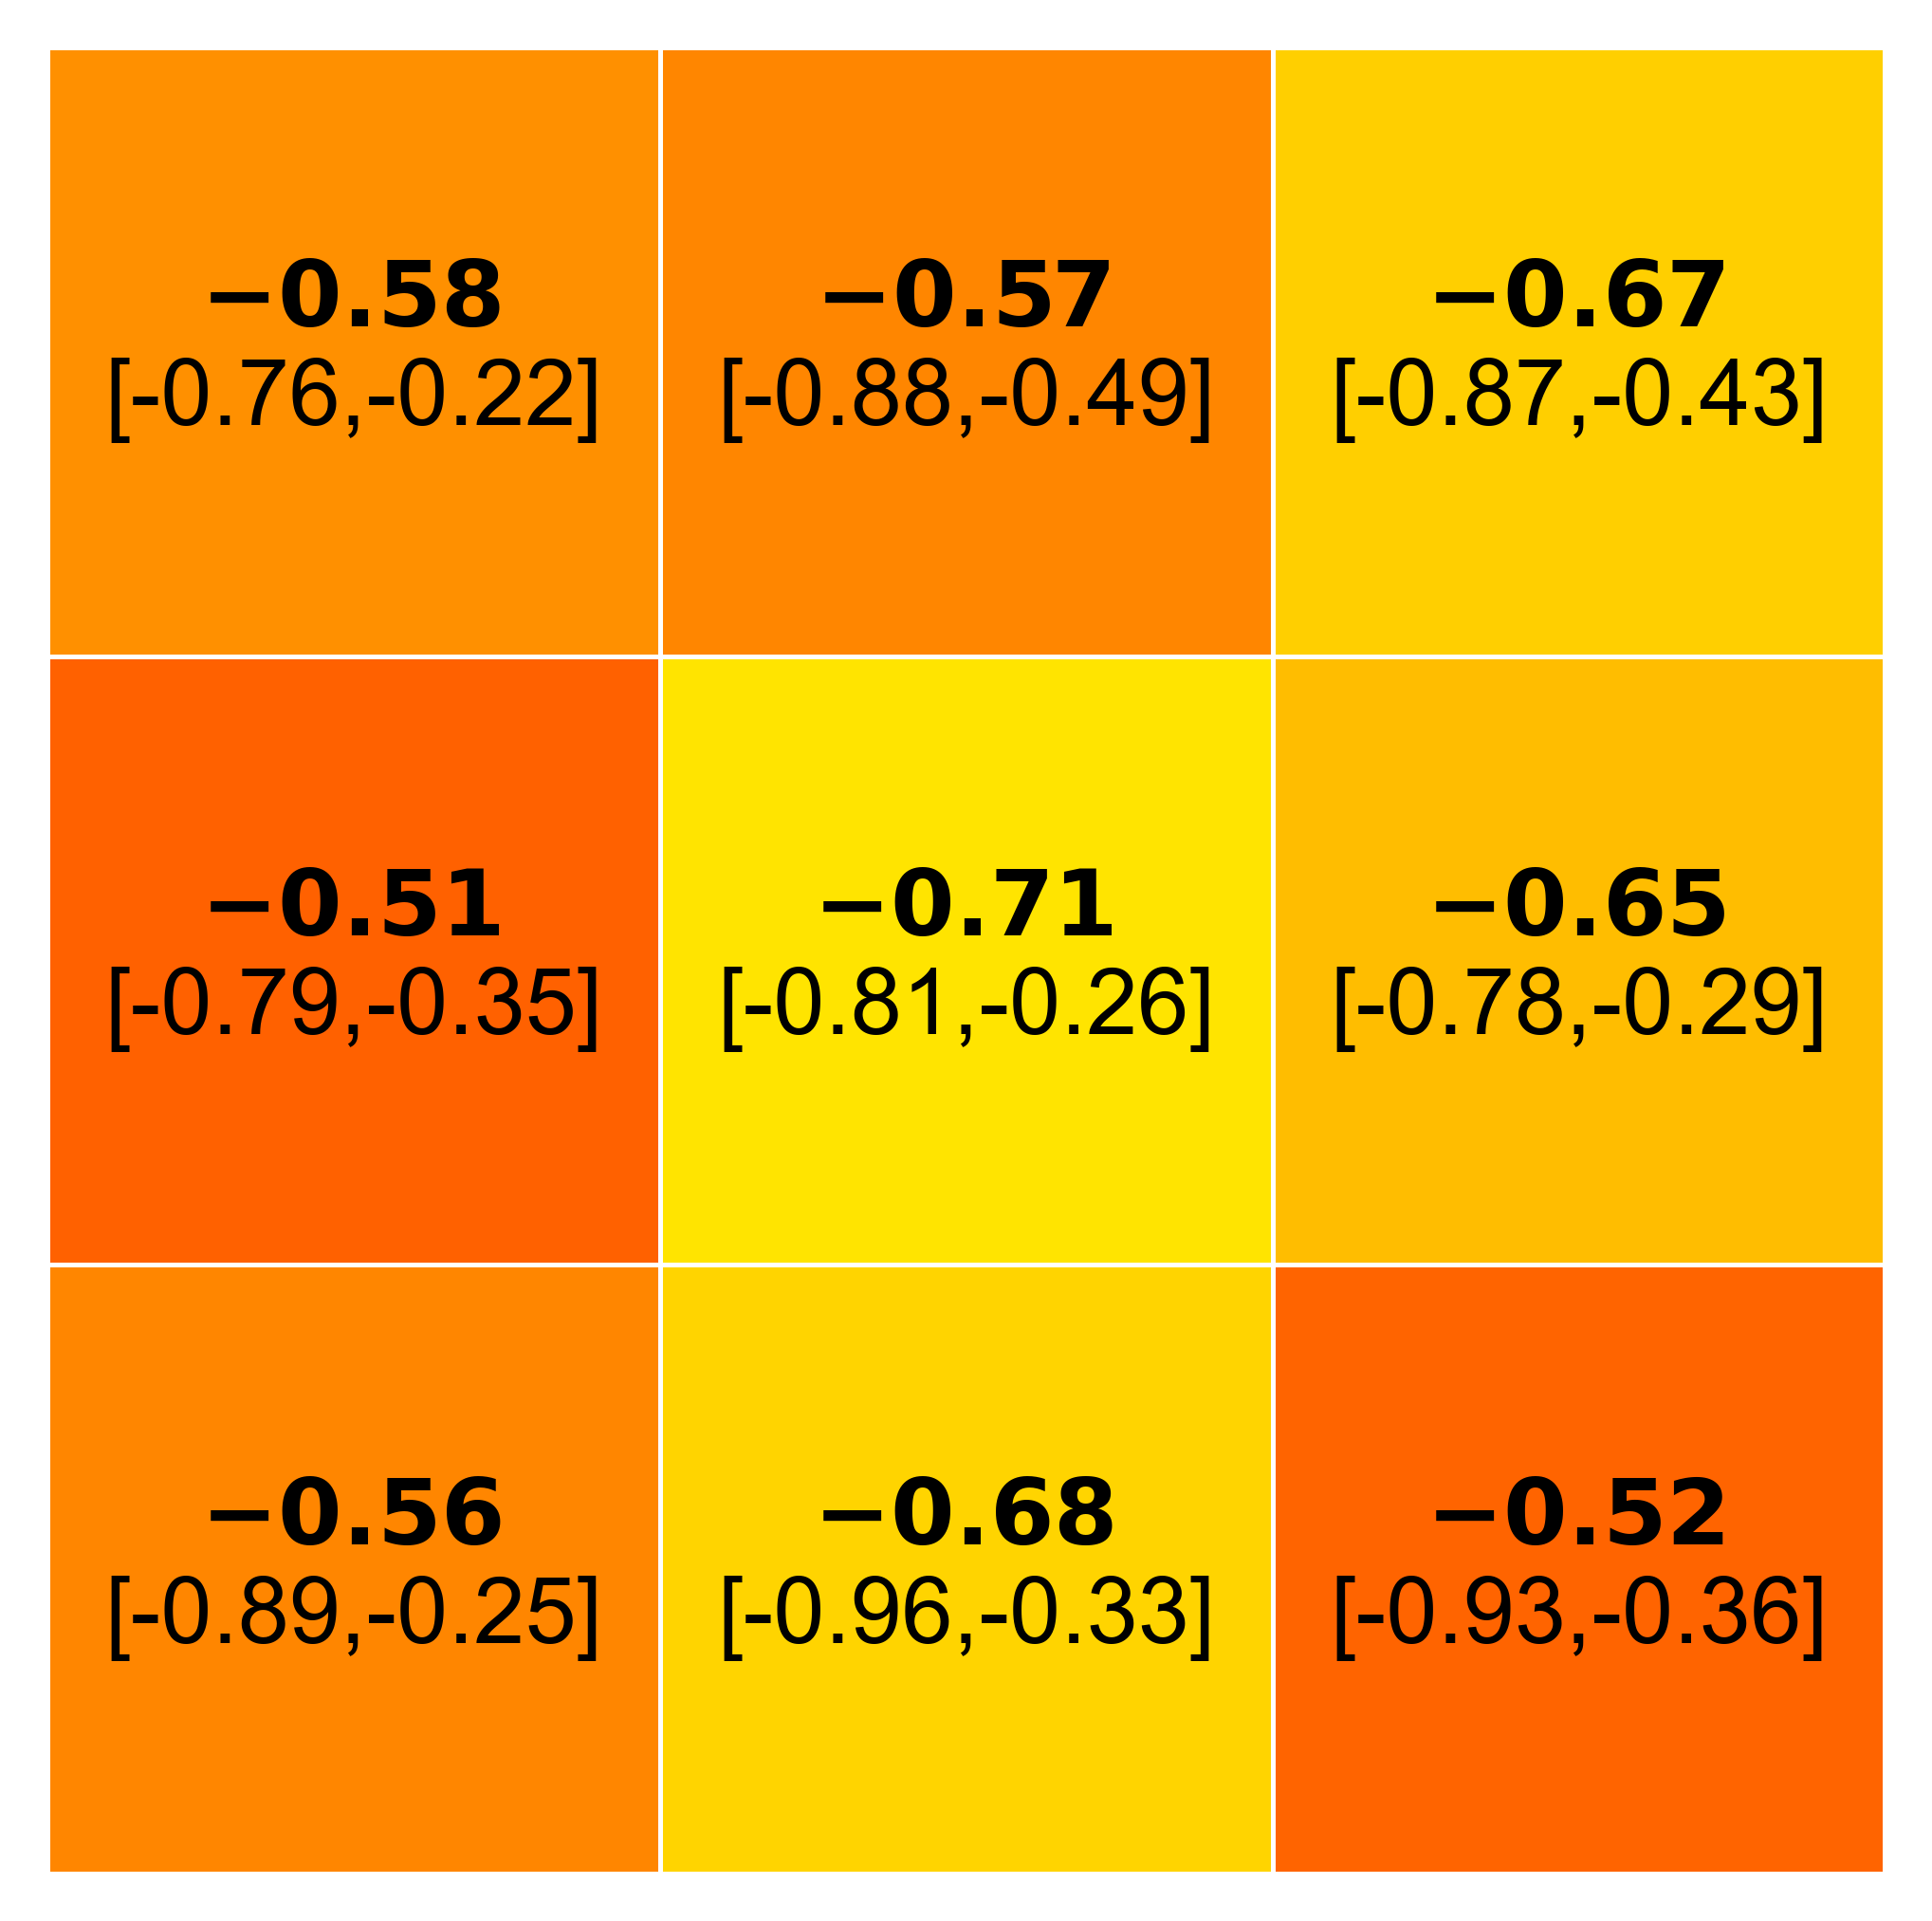

In [40]:
median_HAP = np.nanmedian(HAP_adjust,axis = 0)

median_HAP_map = [median_HAP[:3],median_HAP[3:6],median_HAP[6:]]


formatted_text = (np.asarray([" $\\mathbf{{ {:.2f} }}$  \n[{:.2f},{:.2f}]".format( 
    data, lower,upper) for  data, lower,upper in zip(np.array(median_HAP).flatten(), np.array(lb).flatten(),np.array(ub).flatten(),)]) ).reshape(3, 3) 


fig, axes = plt.subplots(1, 1, figsize=(5,5),sharex=True,sharey = True,dpi=500)
ax = sns.heatmap(median_HAP_map,annot=formatted_text,linewidth=.5,fmt="",annot_kws={"fontsize":14,"color":'black'},
            cmap = 'hot_r',cbar = False,vmin = -1,vmax = 0)

axes.set_yticklabels(['', '', ''],size = 0,color='white')
axes.set_xticklabels(['', '', ''],size = 0,color='white')

fig.savefig('mHAP_figure_heatmap.svg', format='svg', bbox_inches='tight')



In [41]:
median_HAP

array([-0.57914011, -0.56525999, -0.67360258, -0.50930784, -0.70702944,
       -0.64545667, -0.56385904, -0.68242606, -0.51526357])

In [42]:
FA = HAP_adjust
HAP_adjust[:,0]

array([-0.29252454, -0.356044  , -0.52610947, -0.13196855, -0.76771794,
       -0.57960351, -0.66310471, -0.61545652, -0.46589545, -0.80162257,
       -0.57914011])

/opt/anaconda3/envs/CarDpy/lib/python3.8/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/opt/anaconda3/envs/CarDpy/lib/python3.8/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


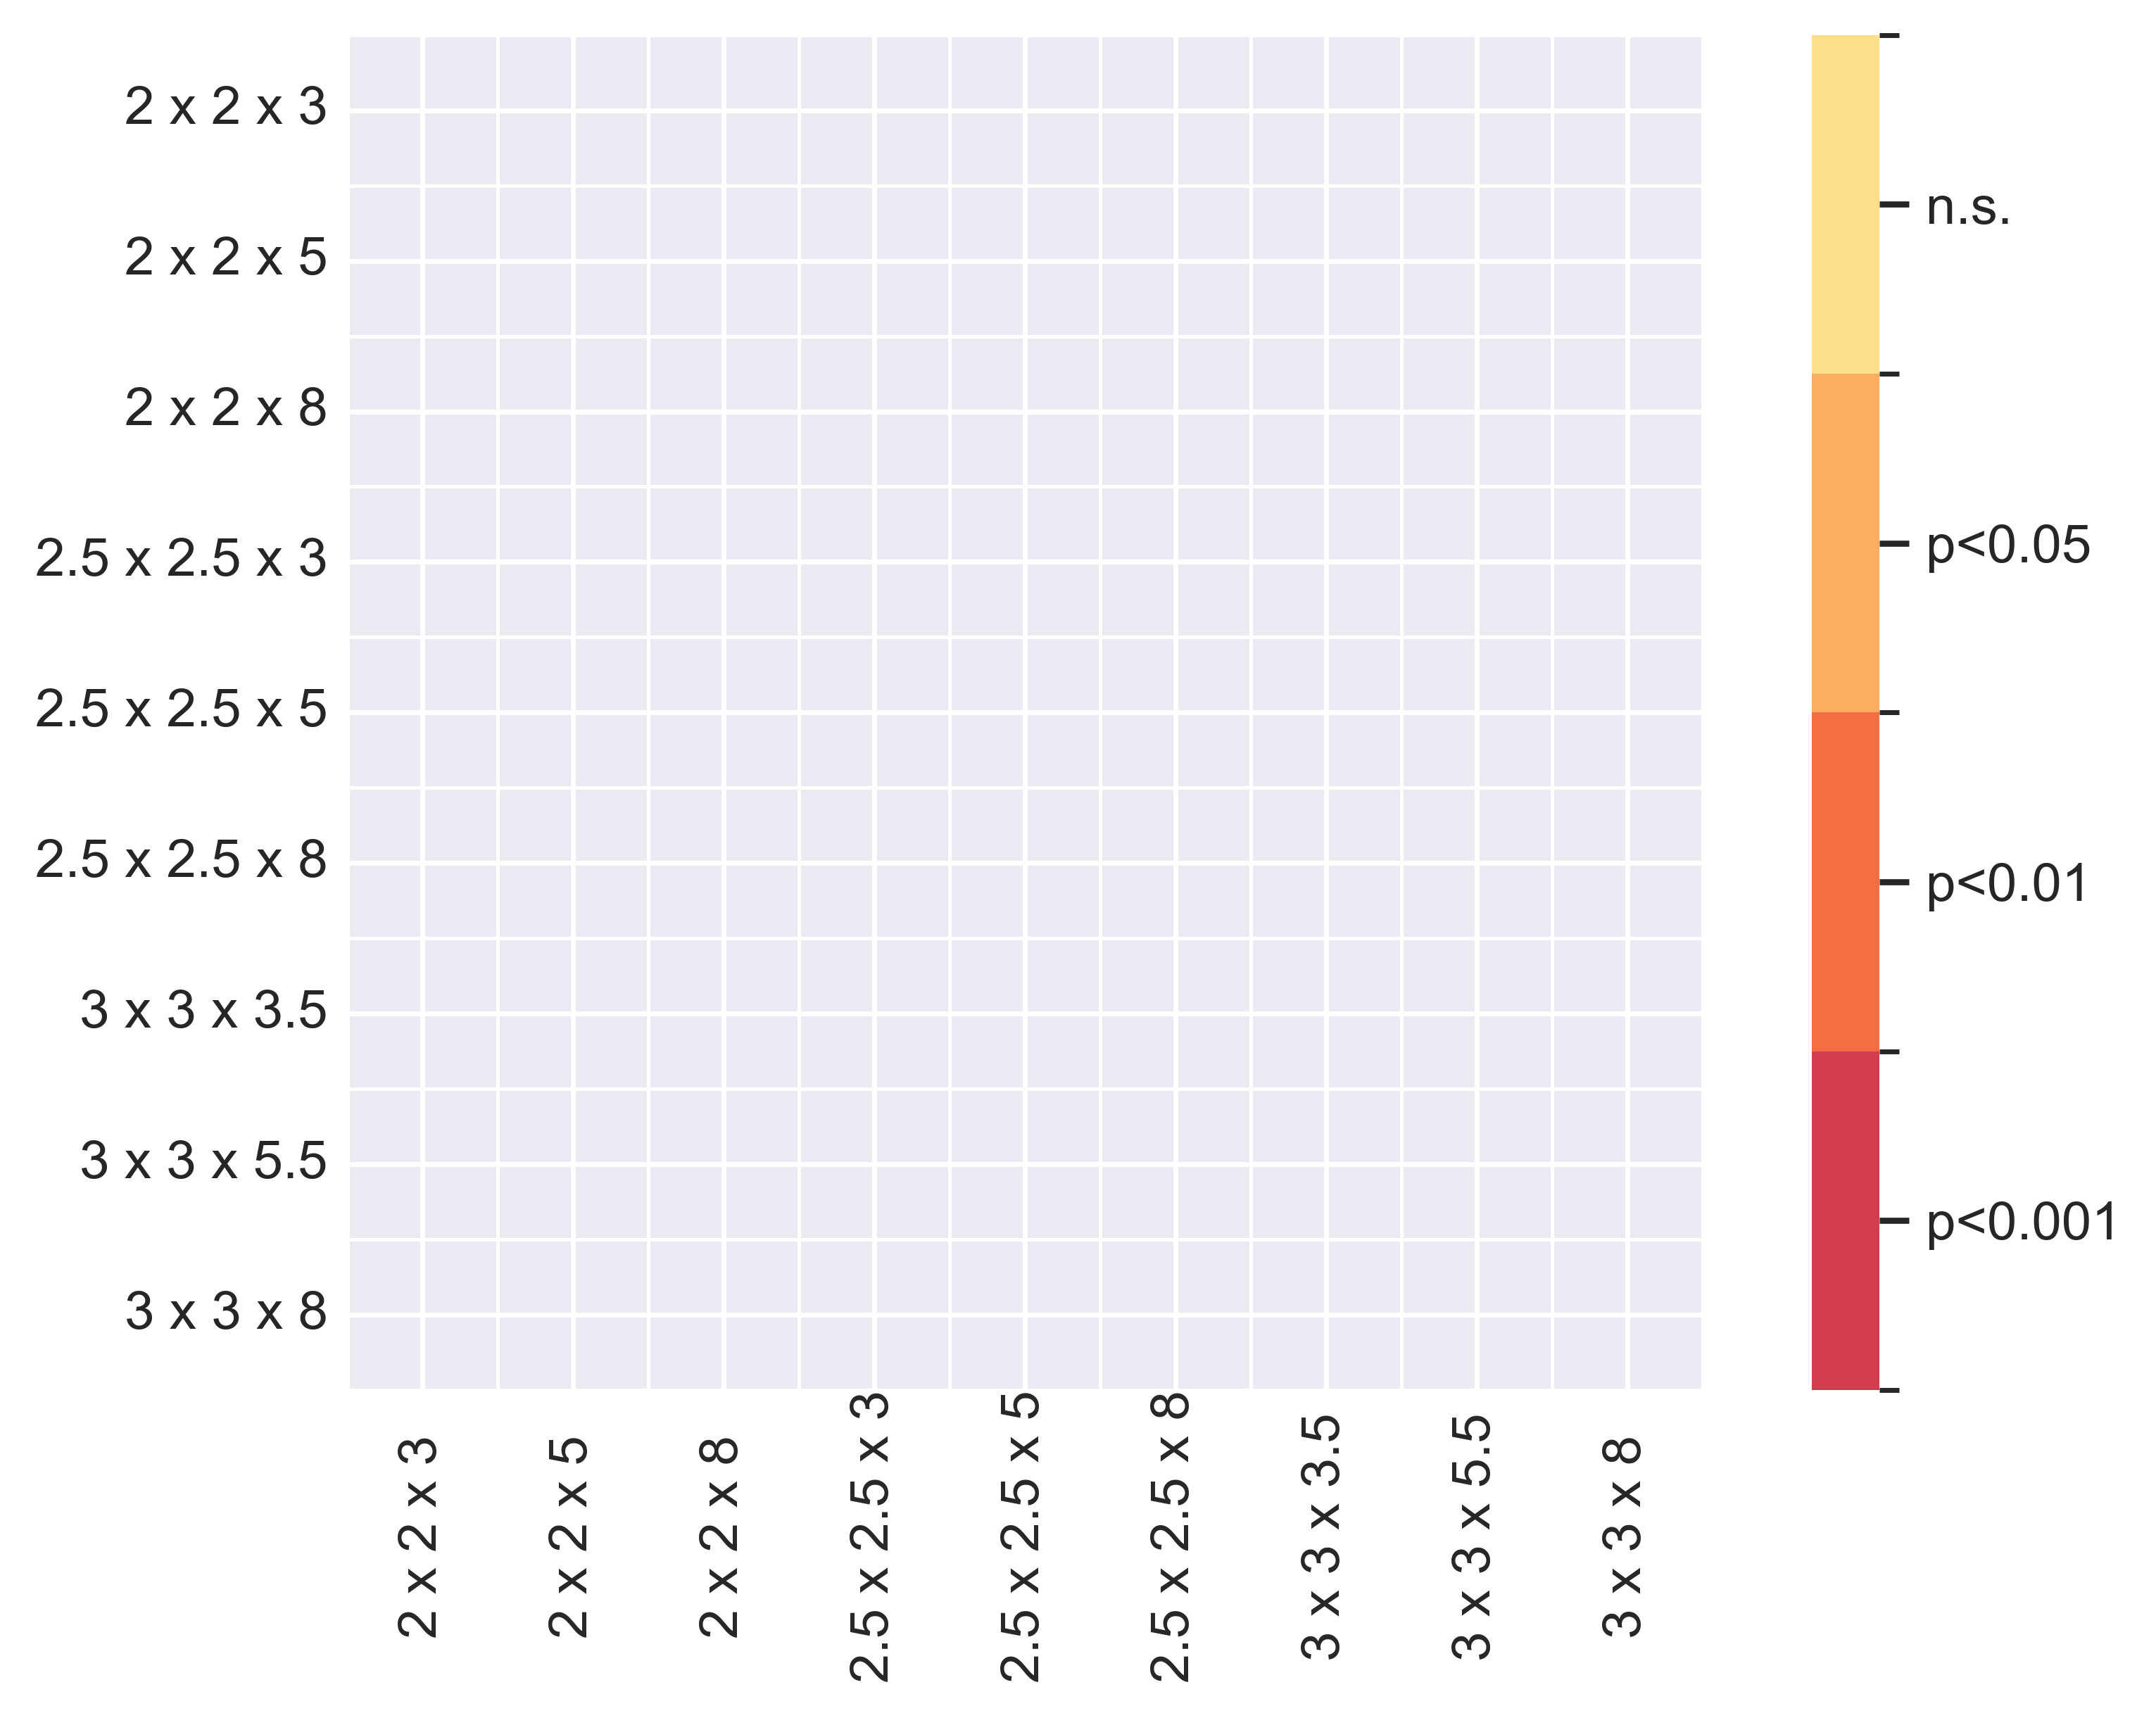

In [43]:
import seaborn as sns
import scikit_posthocs as sp
from scipy import stats
alpha= 0.05

hypothesis = np.zeros((9,9))
hypothesis[:] = np.nan


normal = 0
for ii in range(FA.shape[-1]):
    normal +=stats.shapiro(FA[:,ii])[0] >alpha #Normal is greater than alpha


if normal <FA.shape[-1]: # Non-normal distribution
    result = stats.friedmanchisquare(FA[:,0],FA[:,1],FA[:,2],FA[:,3],FA[:,4],FA[:,5],FA[:,6],FA[:,7],FA[:,8])
    if result[1] < alpha:
        test = sp.posthoc_wilcoxon(FA.T,p_adjust = 'holm-sidak')
        hypothesis = test
    else:
        hypothesis = np.zeros((9,9))*np.nan

elif normal ==FA.shape[-1]: # normal distribution data 
    result = stats.f_oneway(FA[:,0],FA[:,1],FA[:,2],FA[:,3],FA[:,4],FA[:,5],FA[:,6],FA[:,7],FA[:,8])
    if result[1] < alpha:
        test = sp.posthoc_ttest(FA.T,p_adjust = 'holm-sidak')
        hypothesis = test 
    else:
        hypothesis = np.zeros((9,9))*np.nan



from matplotlib.colors import BoundaryNorm, ListedColormap
import numpy as np

labels = ["2 x 2 x 3","2 x 2 x 5","2 x 2 x 8",
        "2.5 x 2.5 x 3","2.5 x 2.5 x 5","2.5 x 2.5 x 8",
        "3 x 3 x 3.5","3 x 3 x 5.5","3 x 3 x 8",
        ]


my_colors = [sns.color_palette("Spectral",9)[0], sns.color_palette("Spectral",9)[1], sns.color_palette("Spectral",9)[2], 
            sns.color_palette("Spectral",9)[3]]
my_cmap = ListedColormap(my_colors)
bounds = [0, 0.001, 0.01, 0.05,1]
my_norm = BoundaryNorm(bounds, ncolors=len(my_colors))

fig, axes = plt.subplots(1, 1, figsize=(8,5),sharex=True,sharey = True,dpi=500)
count = 2

mask =  np.tri(hypothesis.shape[0], k=-1)
mask[mask==0] = np.nan
A = hypothesis

ax = sns.heatmap(A,annot = False, linewidth=.5,
            norm=my_norm,cmap = my_cmap,cbar = True,annot_kws={"fontsize":8}, xticklabels=labels, yticklabels=labels,square = True)
c_bar = ax.collections[0].colorbar
c_bar.set_ticks([(0 + 0.001)/2,(0.001+0.01)/2,(0.01+0.05)/2,(0.05+1)/2])
c_bar.set_ticklabels(['p<0.001','p<0.01','p<0.05','n.s.'])  
c_bar.set_ticklabels(['p<0.001','p<0.01','p<0.05','n.s.'])  
ax.set_xticklabels(ax.get_xticklabels(),  ha="center", va="center", position=(0, 0))
ax.tick_params(axis='x', which='major', pad=24)  # Adjust the pad value as needed
ax.tick_params(axis='y', which='major', pad=-2)  # Adjust the pad value as needed


count = count -1

plt.subplots_adjust(wspace=0.05, hspace=0.03)


fig.savefig('mFA_figure_statistics.svg', format='svg', bbox_inches='tight')

# Report HAP Trends 


0 0 0
3 0 1
6 0 2
1 1 0
4 1 1
7 1 2
2 2 0
5 2 1
8 2 2


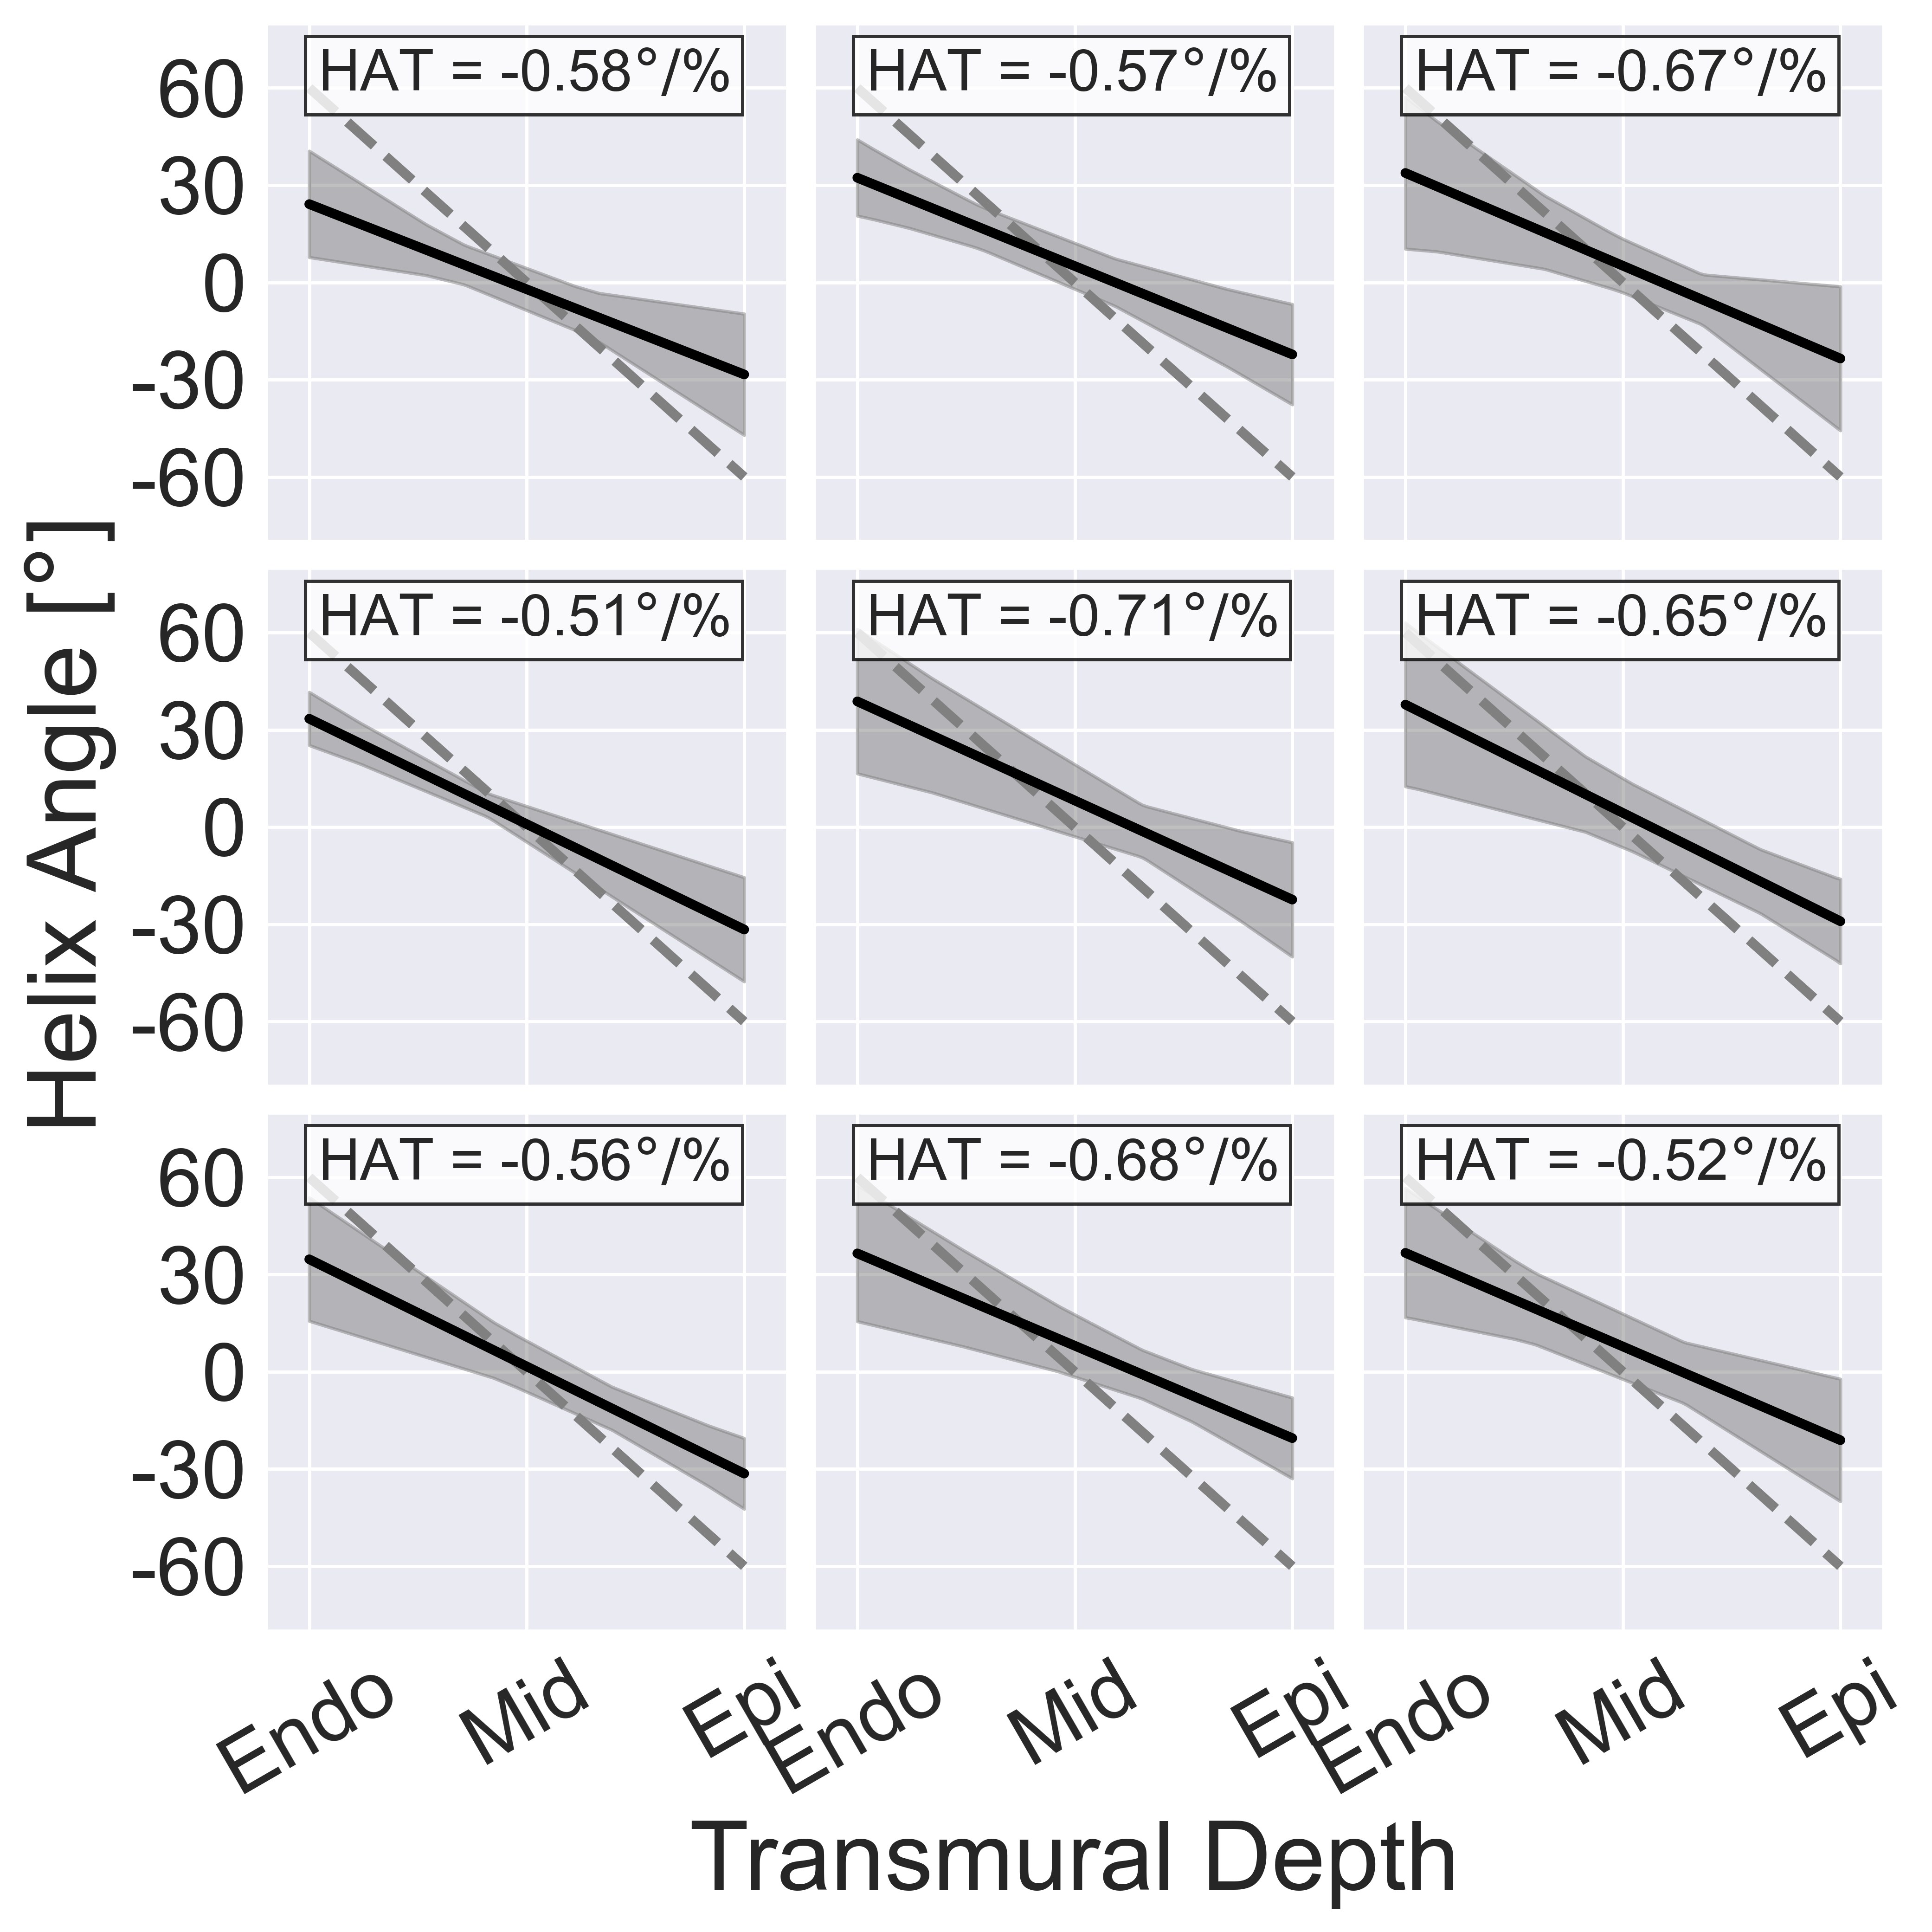

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Example data and settings
xx = np.linspace(0, 1, 100)
custom_palette = sns.color_palette("colorblind")
colors = ['gray']*9

# Create a single figure and axis for all subplots
fig, axes = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True, dpi=500)
count = 0
for row in range(3):
    for col in range(3):
        ii = col * 3 + row
        print(ii, row, col)

        # Plot anticipated slope
        yy2 = 60 + -60 * 2 * xx[:, np.newaxis]
        axes[row, col].plot(xx, yy2, 'gray', linestyle='dashed', linewidth=3)

        # Plot mean across all volunteers 
        yy = epi_end_int[:, ii] + epi_end_slope[:, ii] * xx[:, np.newaxis]
        yy_mean = np.mean(yy, axis=1)
        axes[row, col].plot(xx, yy_mean, 'k', linewidth=3,label = 'HAP = {:.2f}$\degree/$%'.format(med_all[count]))

        # 95% confidence interval 
        yy_sort = np.sort(yy, axis=1)
        min_idx = int(np.round(0.025 * yy_sort.shape[1]))
        max_idx = min(int(np.round(0.975 * yy_sort.shape[1])), yy_sort.shape[1] - 1)
        width = yy_sort[:, max_idx] - yy_sort[:, min_idx]
        yy_lb = yy_mean - width/2
        yy_ub = yy_mean + width/2
        axes[row, col].fill_between(xx, yy_lb, yy_ub, alpha=0.5, color=colors[ii])

        # Figure Settings
        x_tick_labels = ['Endo', 'Mid', 'Epi']
        x_tick_values = [0, 0.5, 1.0]
        axes[row, col].set_xticks(x_tick_values)
        axes[row, col].set_xticklabels(x_tick_labels, size=25, rotation=30)

        y_tick_values = [-60, -30, 0, 30, 60]
        y_tick_labels = y_tick_values
        axes[row, col].set_yticks(y_tick_values)
        axes[row, col].set_yticklabels(y_tick_labels, size=25)

        axes[row, col].set_xlim([-0.1, 1.1])
        axes[row, col].set_ylim([-80, 80])

        # Adjust tick label padding
        axes[row, col].tick_params(axis='both', which='both', pad=-0.1)
        #axes[row,col].legend()

        count+=1


# Add custom text labels
label_positions = [(0.1, 0.95)]*9
label_texts = ['HAT = {:.2f}$\degree/$%'.format(med_all[count]) for count in range(9)]

for i, ax in enumerate(axes.flat):
    ax.text(label_positions[i][0], label_positions[i][1], label_texts[i], transform=ax.transAxes, fontsize=18, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))



axes[1, 0].set_ylabel('Helix Angle [$\degree$]',size = 30)
axes[2, 1].set_xlabel('Transmural Depth',size = 30)
plt.subplots_adjust(wspace=0.05, hspace=0.05) 
plt.show()
fig.savefig('hat_trend.svg', format='svg', bbox_inches='tight')


# Images

In [45]:
# Choose a Volunteer to load: 
vv = 5

In [46]:
ims = []
maps = []
for ii in range(9):
    main_path = os.path.join(os.path.abspath('../../Data/NifTi/'+vol_idx[vv]) + '/'+ vox_folder[ii] + '/ADC_Filtered')
    path_segmentation = os.path.join(os.path.abspath('../../Data/Segmentations/'+vol_idx[vv]),vox_folder[ii])
    path_maps  = os.path.join(os.path.abspath('../../Data/DTI_Maps/'+vol_idx[vv])+'/'+ vox_folder[ii] + '/ADC_Filtered')

    NifTi_path = glob.glob(os.path.join(main_path, '*Averaged', '*.nii'))[0]
    header_path              = glob.glob(os.path.join(main_path, '*Averaged', '*.header'))[0]
    b_values_path            = glob.glob(os.path.join(main_path, '*Averaged', '*.bvals'))[0]
    b_vectors_path           = glob.glob(os.path.join(main_path, '*Averaged', '*.bvecs'))[0]


    Seg_path    = os.path.join(path_segmentation)
    Maps_Folder = os.path.join(path_maps)

    
    [data, b_vals_stacked, b_vecs_stacked, Header, _, _] = NifTi_Reader(NifTi_path, b_values_path, b_vectors_path, header_path)
    ims.append(data)

    myo_mask = loadmat(os.path.join(Seg_path,'Interpolated_mask.mat'))['Mask']
    myo_mask = myo_mask.astype('float')
    myo_mask[myo_mask == 0] = np.nan

    Standard_DTI_Metrics = loadmat(os.path.join(Maps_Folder, 'cDTI_Metrics.mat'))
    maps.append(Standard_DTI_Metrics['HA']*myo_mask) 
    

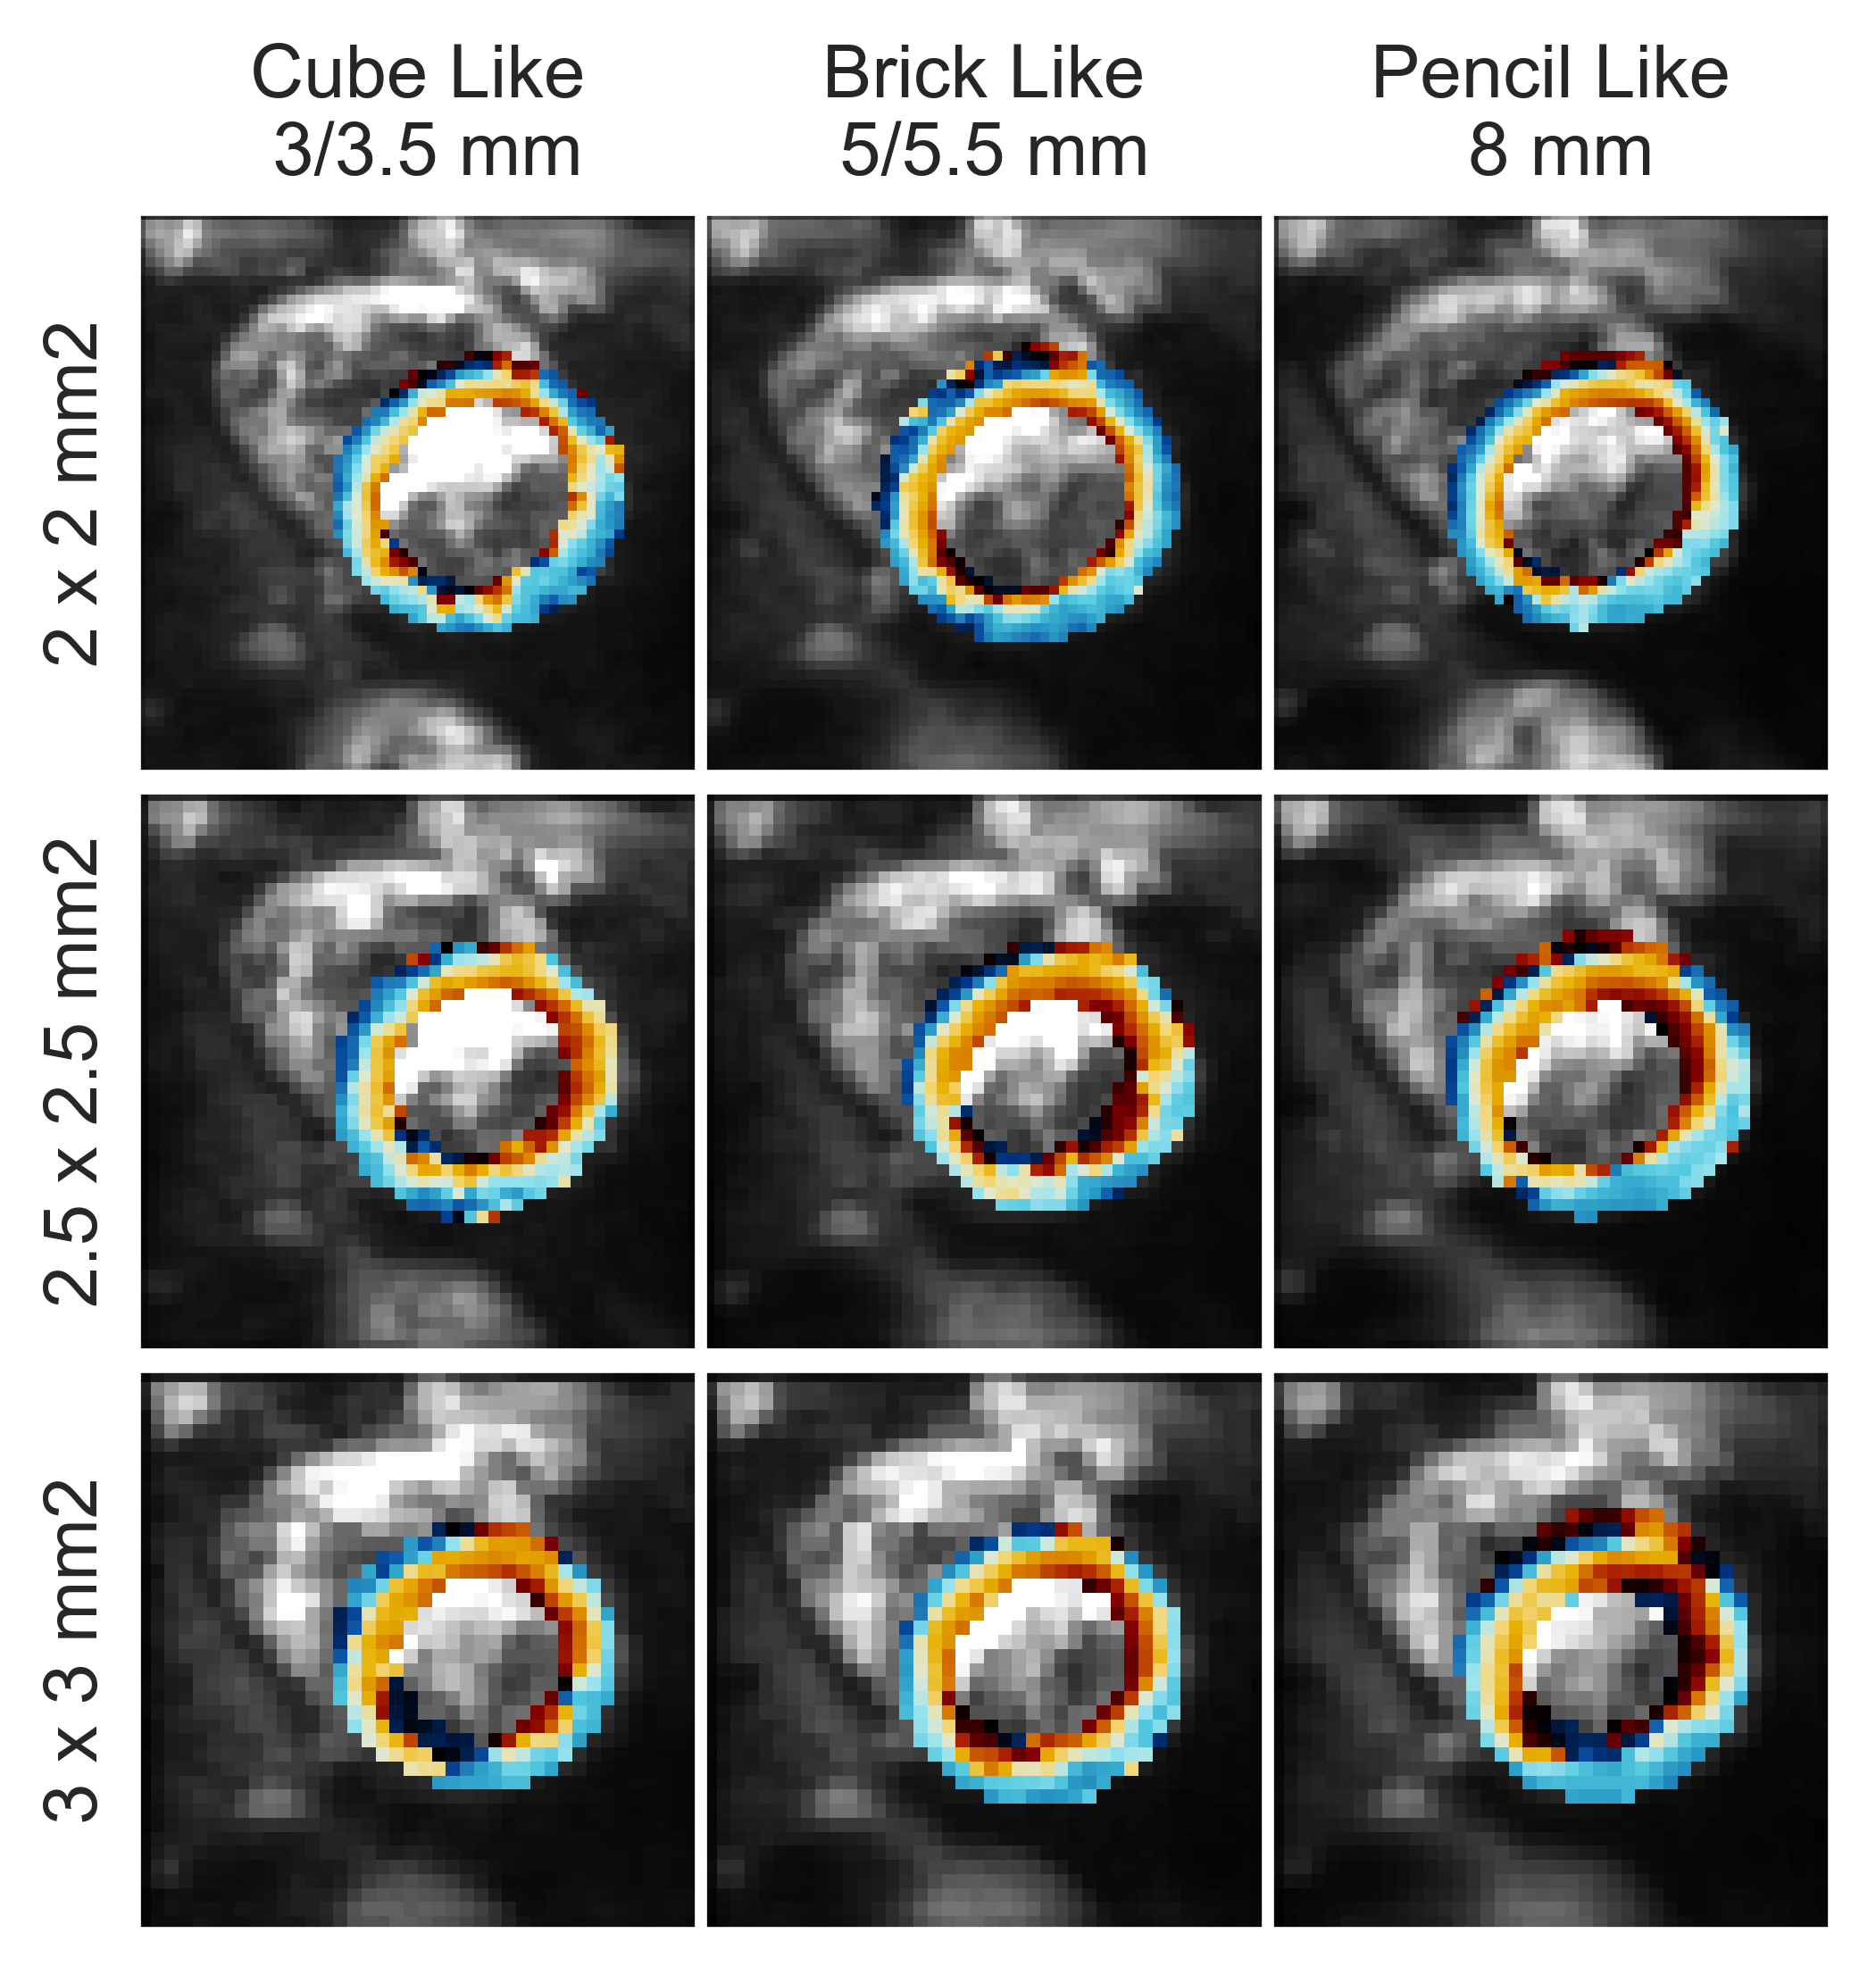

In [47]:
fig, axes = plt.subplots(3, 3, figsize=(5,5),dpi=500)

count = 0
for ii in range(3):
    for jj in range(3):
        ax = axes[ii,jj]
        ax.imshow(ims[count][:,:,0,0],cmap = 'gray',vmin = 0,vmax = 120)
        ax.imshow(maps[count][:,:,0],cmap = cDTI_cmaps['HA'],vmin = -90,vmax = 90)
        ax.set_yticks([])
        ax.set_xticks([])
        ax.grid(False)

        count +=1
        
plt.subplots_adjust(wspace=-0.05, hspace=0.03)

axes[0,0].set_title('Cube Like\n 3/3.5 mm')
axes[0,1].set_title('Brick Like\n 5/5.5 mm')
axes[0,2].set_title('Pencil Like\n 8 mm')


axes[0,0].set_ylabel('2 x 2 mm2')
axes[1,0].set_ylabel('2.5 x 2.5 mm2')
axes[2,0].set_ylabel('3 x 3 mm2')

fig.savefig('HA_figure_images.svg', format='svg', bbox_inches='tight')

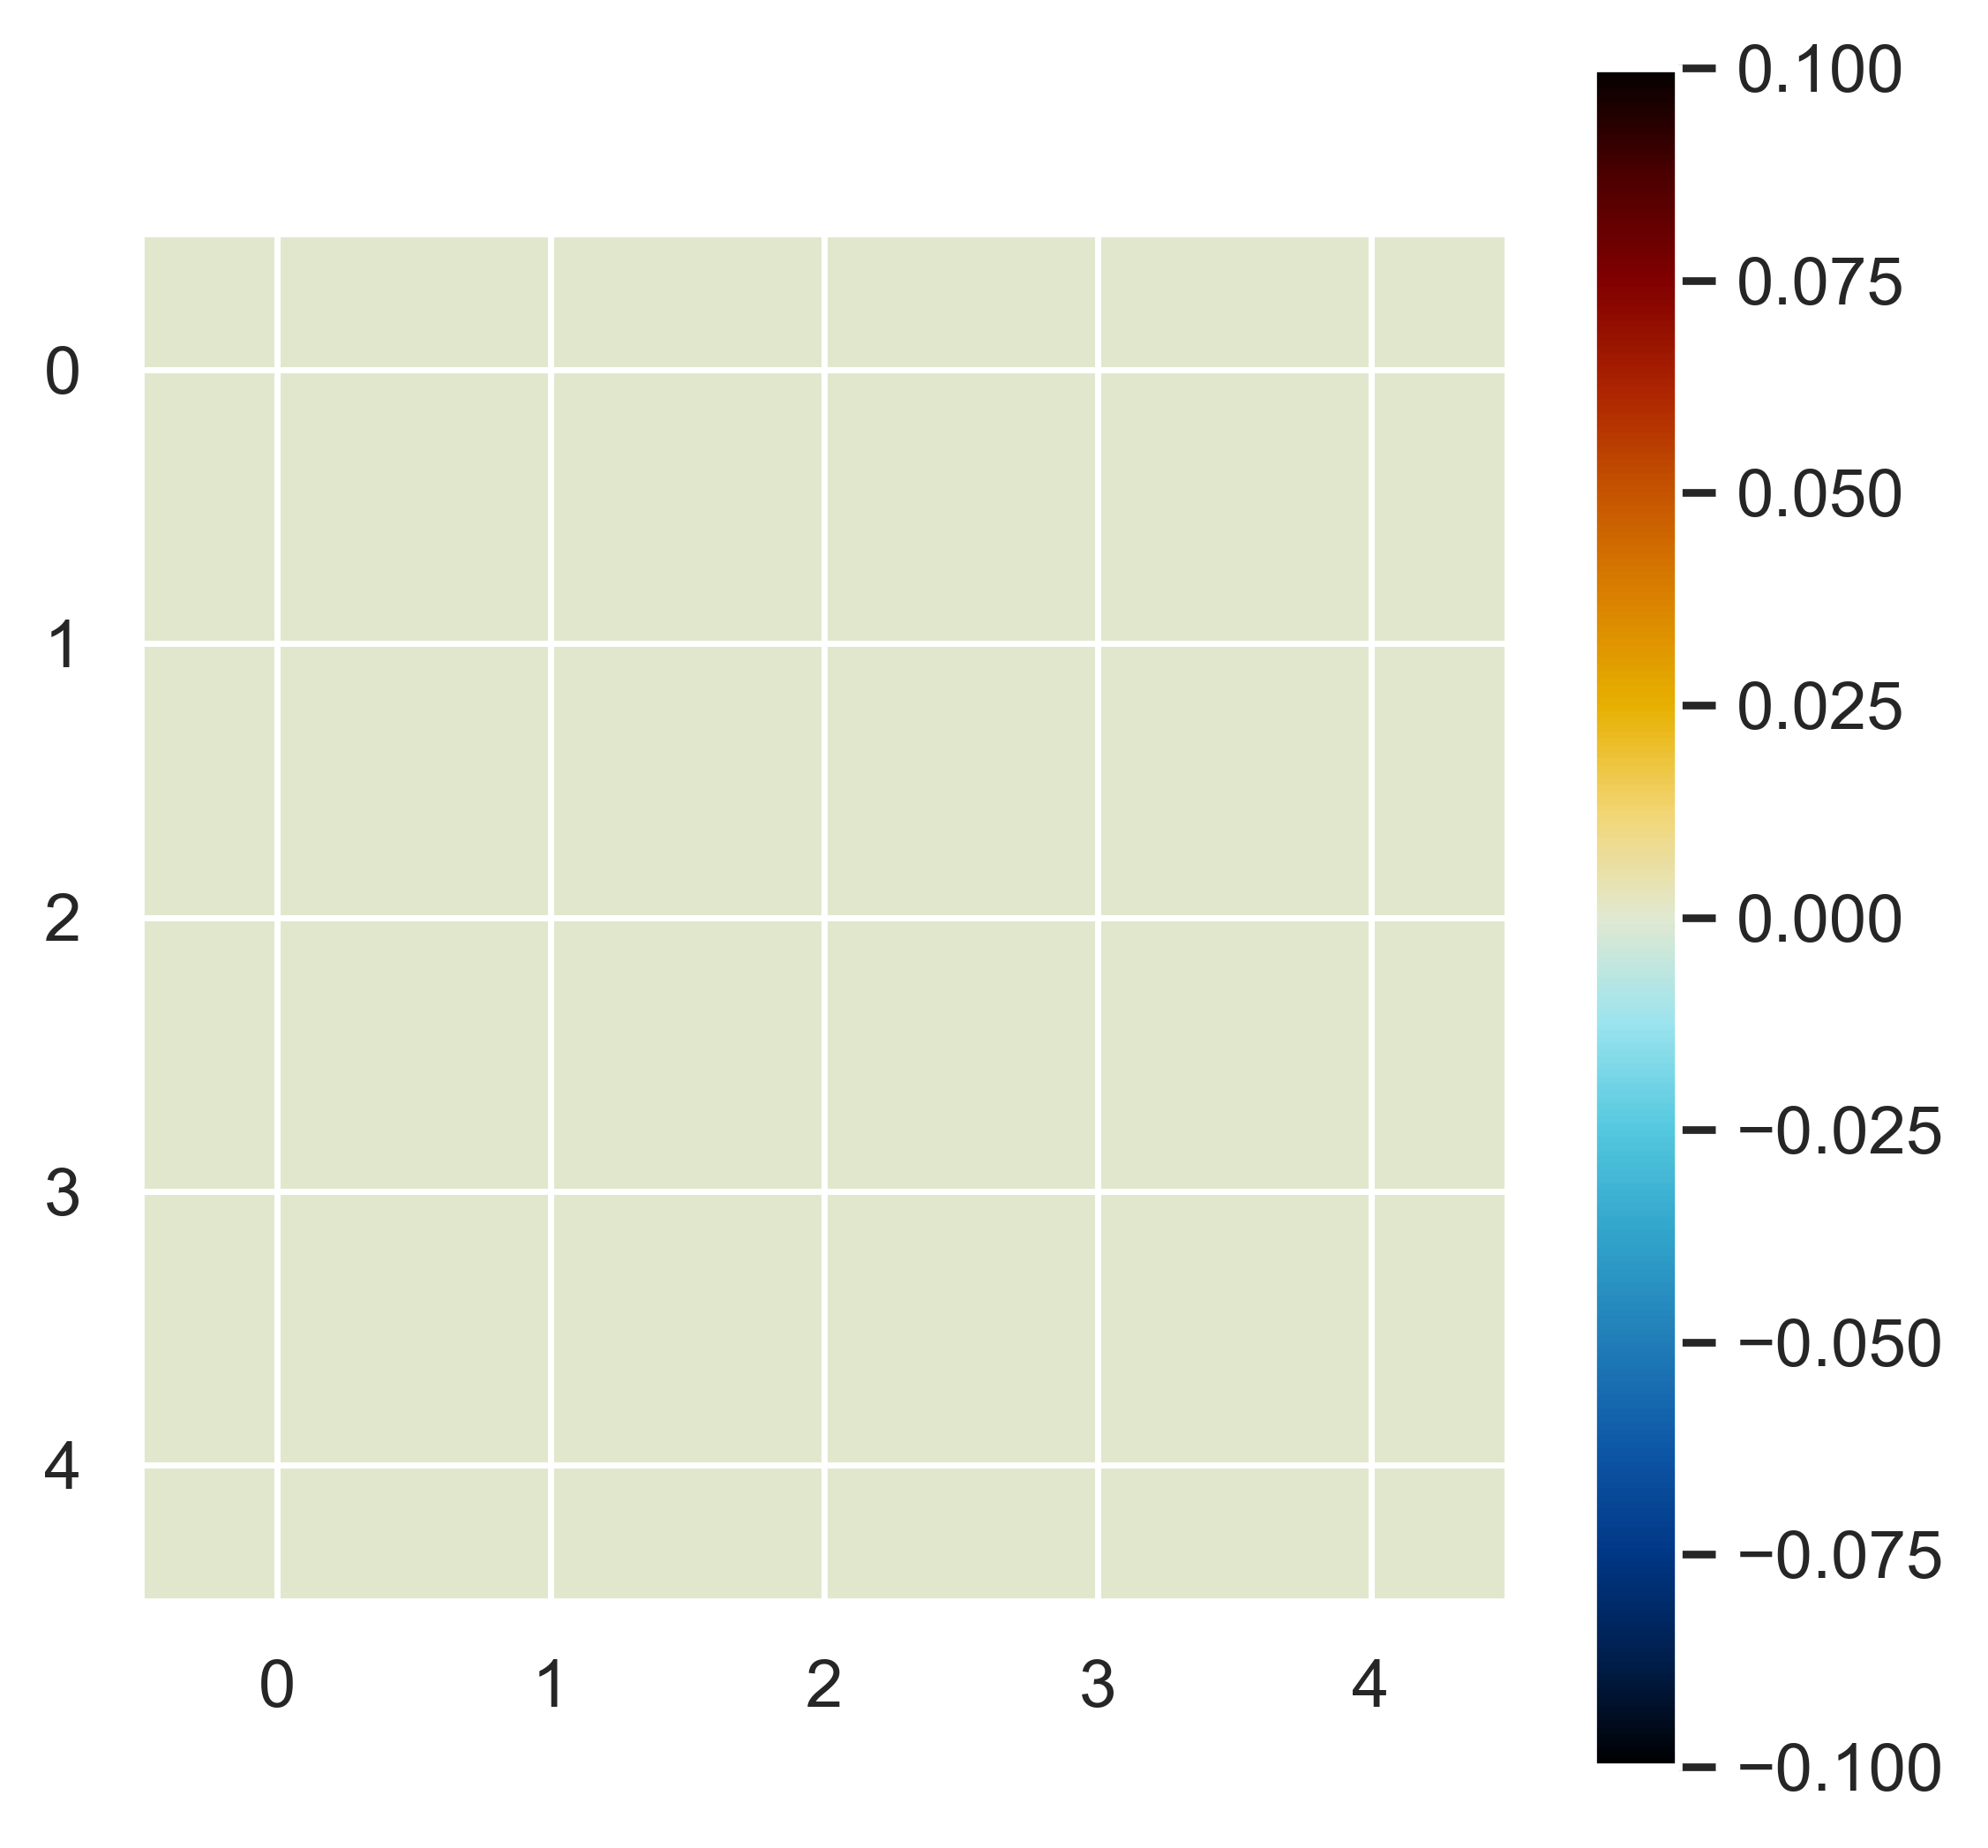

In [48]:
fig, axes = plt.subplots(1, 1, figsize=(5,5),dpi=500)
plt.imshow(np.zeros((5,5)),cmap = cDTI_cmaps['HA'])
plt.colorbar()

fig.savefig('HA_figure_colormap.svg', format='svg', bbox_inches='tight')

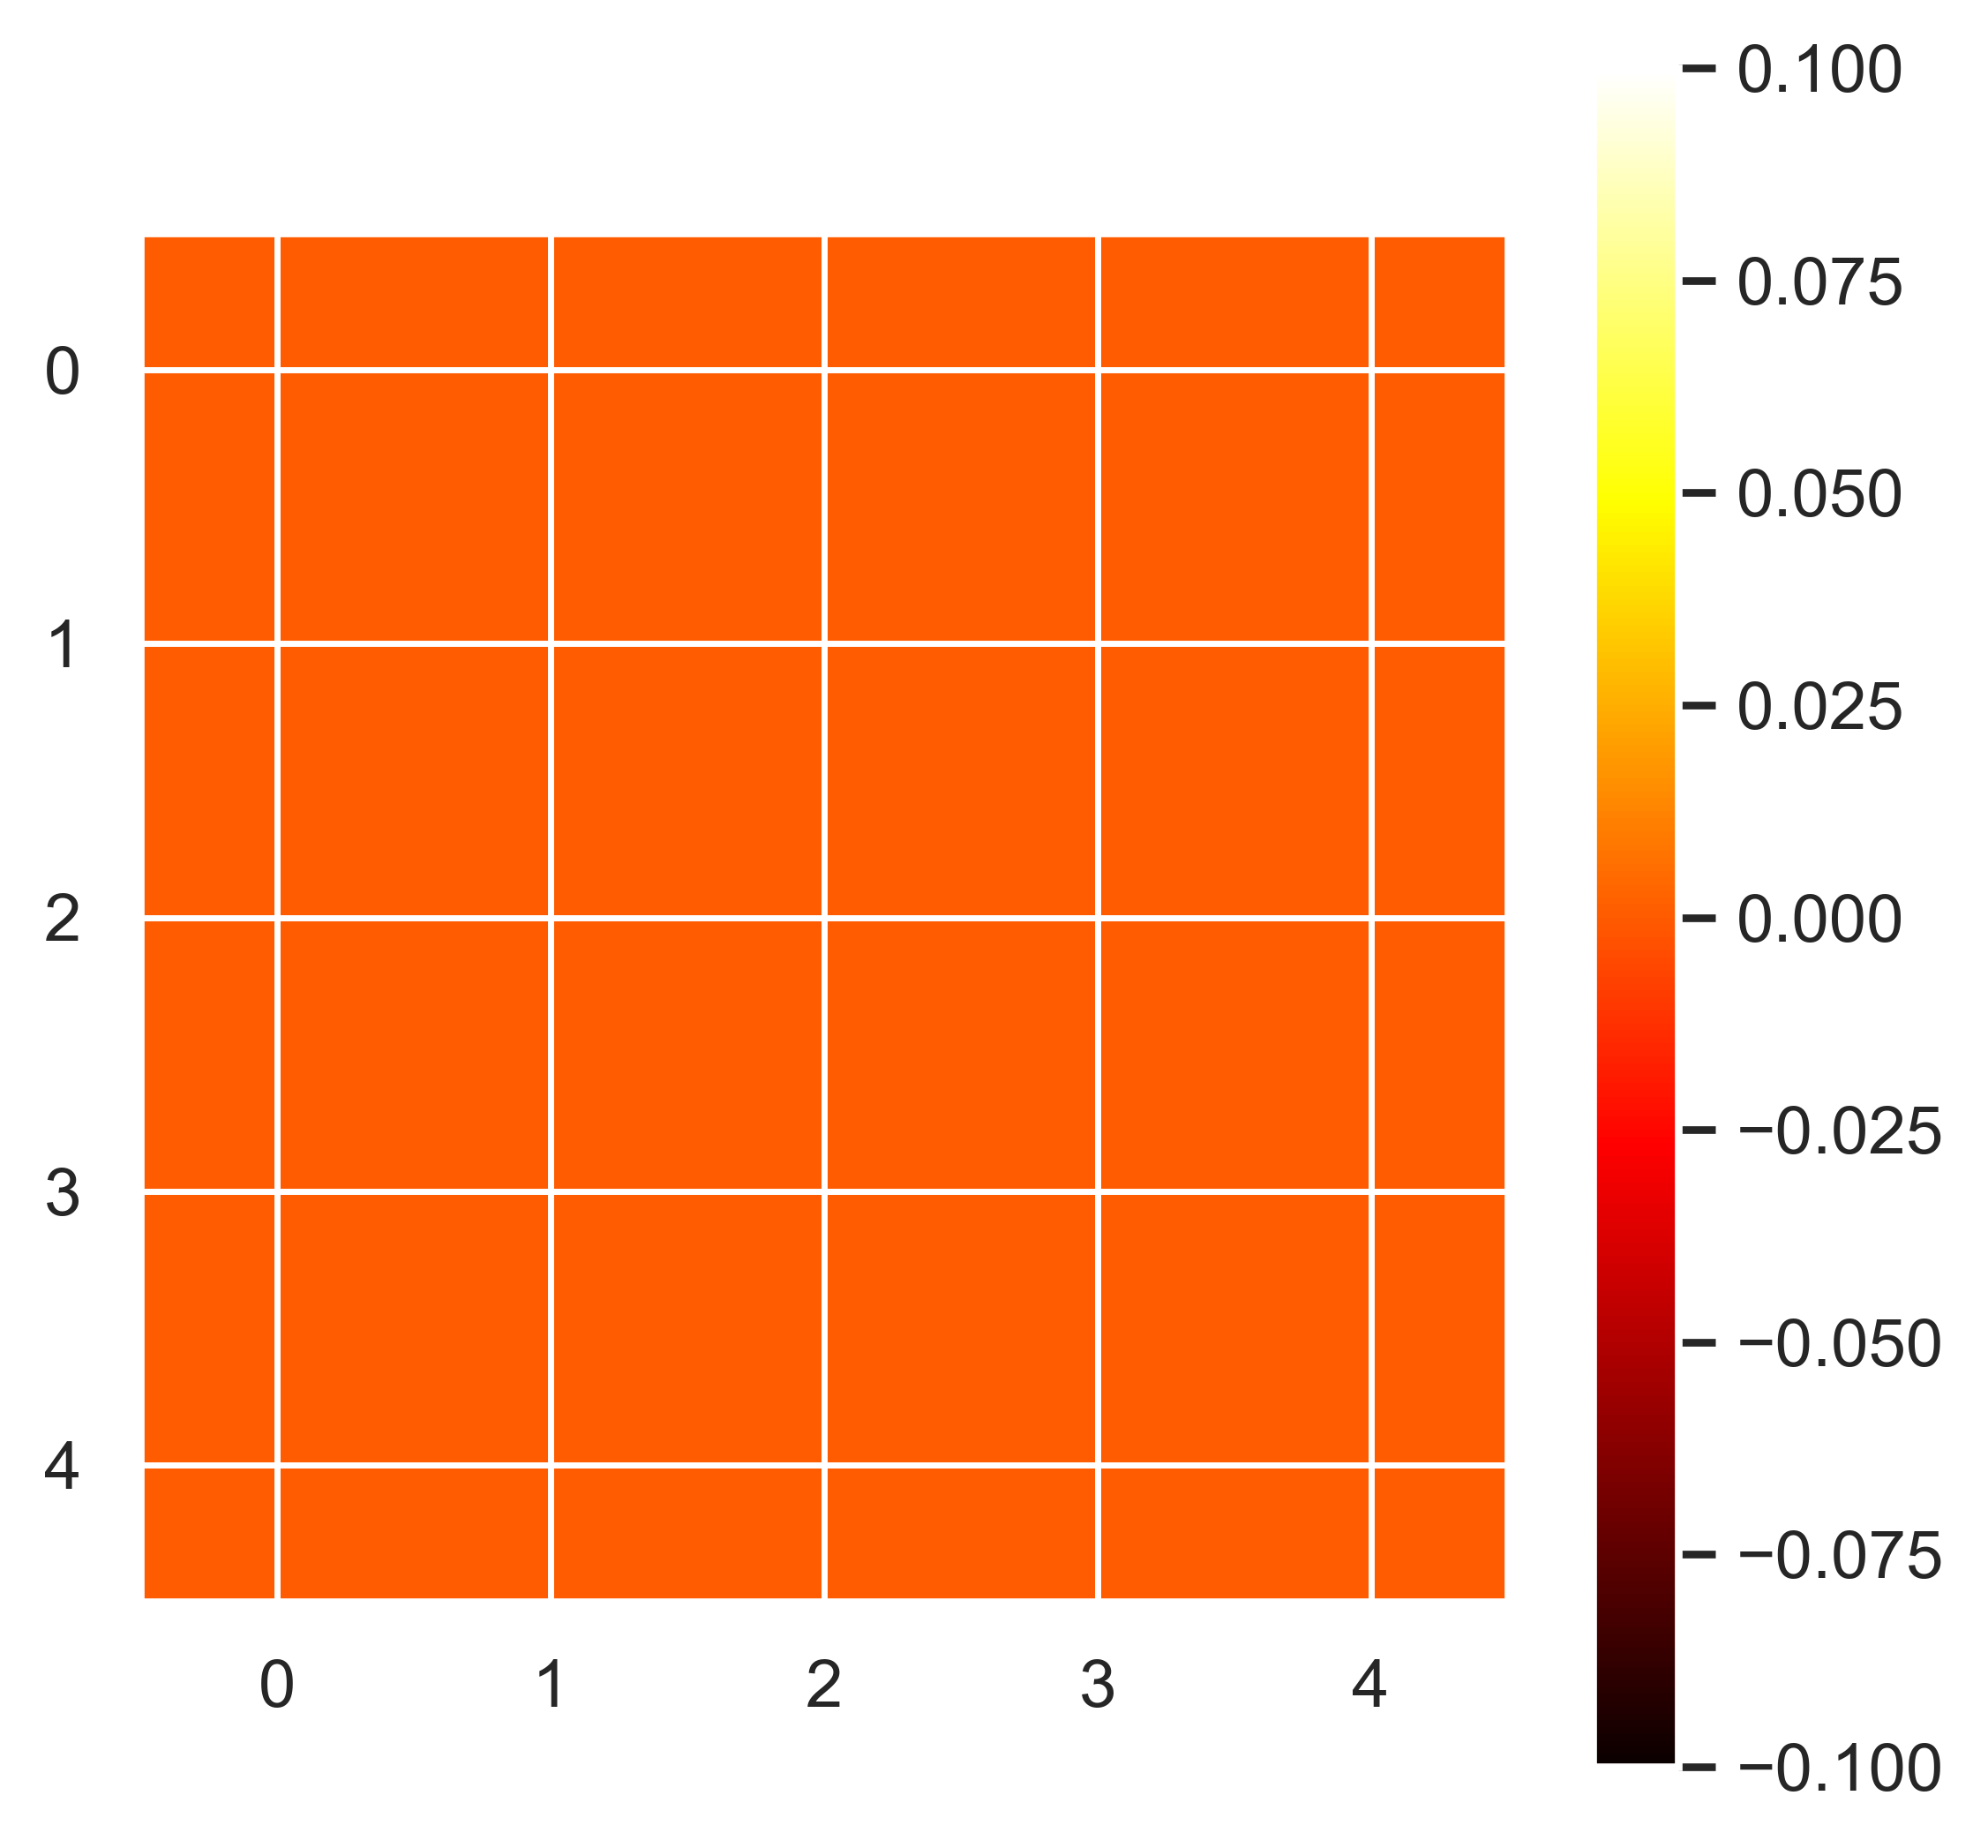

In [49]:
fig, axes = plt.subplots(1, 1, figsize=(5,5),dpi=500)
plt.imshow(np.zeros((5,5)),cmap = 'hot')
plt.colorbar()

fig.savefig('HAP_figure_colormap.svg', format='svg', bbox_inches='tight')

# AHA Segments

In [50]:
def Endo2Epi_grid(LV_Mask):
    import skimage
    import numpy as np
    from scipy.interpolate import griddata

    rows    = LV_Mask.shape[0]
    columns = LV_Mask.shape[1]
    slices  = LV_Mask.shape[2]
    grid    = np.zeros([rows, columns, slices])

    for slc in range(slices):

        tmp_mask = np.ones([rows, columns]) - LV_Mask[:, :, slc]
        labels = skimage.measure.label(tmp_mask, connectivity = 1, background = 0, return_num = True)
        

        Epi_Outside = np.zeros([rows, columns])
        Endo_inside = np.zeros([rows, columns])

        Epi_Outside[labels[0] == 1] = 1
        Endo_inside[labels[0] == 2] = 1

        [epi_x,  epi_y]             = np.where(Epi_Outside == 1)
        [endo_x, endo_y]            = np.where(Endo_inside == 1)
        epi  = np.stack((epi_y, epi_x), axis=1)
        endo  = np.stack((endo_y, endo_x), axis=1)
        points = np.vstack((epi,endo))

        epi_val  = np.ones((epi_x.shape[0], 1))
        endo_val = np.zeros((endo_x.shape[0], 1))    
        values   = np.vstack((epi_val,endo_val))

        x = np.linspace(0, rows - 1,    rows)
        y = np.linspace(0, columns - 1, columns)
        xi, yi = np.meshgrid(y, x)
        tmp_grid = np.squeeze(griddata(points, values, (xi, yi), method='cubic')) * LV_Mask[:, :, slc]
        grid[:, :, slc] = tmp_grid
    return grid

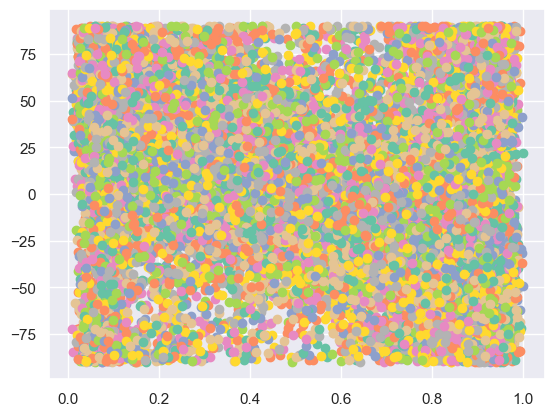

In [51]:
segment_mean= []

for vv in range(11):
    vol_list = []
    for ii in range(9):
        main_path = os.path.join(os.path.abspath('../../Data/NifTi/'+vol_idx[vv]) + '/'+ vox_folder[ii] + '/ADC_Filtered')
        path_segmentation = os.path.join(os.path.abspath('../../Data/Segmentations/'+vol_idx[vv]),vox_folder[ii])
        path_maps  = os.path.join(os.path.abspath('../../Data/DTI_Maps/'+vol_idx[vv])+'/'+ vox_folder[ii] + '/ADC_Filtered')

        Seg_path    = os.path.join(path_segmentation)
        Maps_Folder = os.path.join(path_maps)

        myo_mask = loadmat(os.path.join(Seg_path,'AHA_mask.mat'))['AHA']
        myo_mask = myo_mask.astype('float')
        myo_mask[myo_mask == 0] = np.nan

        Cardiac_DTI_Metrics = loadmat(os.path.join(Maps_Folder, 'cDTI_Metrics.mat'))
        data = Cardiac_DTI_Metrics['HA']

        AHA_Masks = []
        for ii in range(17):
            tmp = np.copy(myo_mask)
            tmp[myo_mask != ii + 1] = np.nan
            tmp[myo_mask == ii + 1] = 1
            AHA_Masks.append(tmp)

        aha = []

        labels = np.unique(myo_mask)
        
        
        LV_Mask_tmp = np.copy(myo_mask)
        LV_Mask_tmp[LV_Mask_tmp > 0]  = 1
        LV_Mask_tmp = np.nan_to_num(LV_Mask_tmp)
        Grid          = Endo2Epi_grid(np.nan_to_num(LV_Mask_tmp))

        
        for label in labels[:-1]:
            if label != np.nan:
                label_adj = label - 1
                data = Cardiac_DTI_Metrics['HA']
                roi_data = np.zeros_like(data)
                roi_data[myo_mask == label_adj] = data[myo_mask == label_adj]
                roi_data[roi_data ==0] = np.nan

                AHA_WD  = Grid * AHA_Masks[int(label_adj)]
                tmp_WD  = AHA_WD.flatten()
                tmp_WD  = tmp_WD[~np.isnan(AHA_WD.flatten())]

                AHA_HA  = data * AHA_Masks[int(label_adj)]
                tmp_HA  = AHA_HA.flatten()
                tmp_HA  = tmp_HA[~np.isnan(AHA_WD.flatten())]


                x = np.copy(tmp_WD)
                y = np.copy(tmp_HA)

                valid_idx = ~np.isnan(y)

                # Keep only valid values in both x and y
                x = x[valid_idx]
                y = y[valid_idx]

                model = LinearRegression().fit(x[:, np.newaxis], y[:, np.newaxis])
                aha.append(model.coef_[0][0] / 100)

                x_interpolated = np.linspace(0, 1, 101)
                y_interpolated = model.intercept_ + model.coef_ * x_interpolated[:, np.newaxis]
                #X_BE_data.append(list(x_interpolated))
                #Y_BE_data.append(list(y_interpolated[:,0]))

                plt.plot(tmp_WD, tmp_HA, 'o')





                #aha.append(np.nanmean(roi_data))
               
                #aha.append(HAP)
                
                


        vol_list.append(aha)
    
    segment_mean.append(vol_list)

segment_avg_array = np.array(segment_mean)
segment_group_med = np.nanmedian(segment_avg_array,axis = 0)

In [52]:
median_HAP.shape

(9,)

In [53]:
segment_avg_array.shape

(11, 9, 6)

# AHA

In [54]:
import seaborn as sns

# Looking at Confidence intervals of the phase differences seeing if there is significant decrease with increasing motion compensation
import scikit_posthocs as sp
from scipy import stats
from statsmodels.stats.multitest import multipletests

alpha =  0.05 / 6 # DO WE NEED BONFERONNI CORRECTION


seg_pvalue = []
seg_idx = []
for vox in range(9):
    alpha= 0.05
    
    hypothesis = []

    for aha in range(6):
        normal = 0
        FA = segment_avg_array[:,vox,aha]
        med = [median_HAP[vox]]*11
        result = stats.ttest_ind(np.array(FA),  np.array(med)) [1]
        hypothesis.append(result)
        #print( med_MD[vox], np.round(result.pvalue,3),MD)
    #reject, hypothesis_corrected, _, _ = multipletests(hypothesis, alpha=alpha, method='holm-sidak')
    #print(hypothesis)
    seg_pvalue.append(hypothesis)
    significant_indices = [idx+7 for idx, p in enumerate(hypothesis) if p < 0.05 / 6 ]
    print('Hypthesis results for voxel:',vox_folder[vox],  hypothesis,significant_indices)
    seg_idx.append(significant_indices)
    #print(np.round(hypothesis,2),significant_indices, segment_group_med[vox,:-1])


print(significant_indices)

Hypthesis results for voxel: vol_2.0res_3.0sl [0.15671208469516693, 0.4882978141703259, 0.9865356396816334, 0.1159032951498269, 0.2906138152461894, 0.2487474782448777] []
Hypthesis results for voxel: vol_2.0res_5.0sl [0.003339670816607847, 0.42544312818061714, 0.05631524777601564, 0.912109591287148, 0.10484173641207592, 0.7320105540865607] [7]
Hypthesis results for voxel: vol_2.0res_8.0sl [0.06653728056421047, 0.31930477179774797, 0.42839200296247903, 0.016220669527268042, 0.7868574722347866, 0.9990850708543371] []
Hypthesis results for voxel: vol_2.5res_3.0sl [0.04336029114411555, 0.5987835591565323, 0.5299524447860189, 0.17963705736785351, 0.28562973437197237, 0.18211026106908698] []
Hypthesis results for voxel: vol_2.5res_5.0sl [0.6597355150706357, 0.9305340180668322, 0.8148763501298606, 0.06777560982990866, 0.2081093095169951, 0.5882230352721762] []
Hypthesis results for voxel: vol_2.5res_8.0sl [0.4581585496198397, 0.05077850223051592, 0.5114619616721319, 0.3654156662132958, 0.2695

/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_10400/304719845.py:22: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  result = stats.ttest_ind(np.array(FA),  np.array(med)) [1]


In [55]:
import matplotlib as mpl
def bullseye_plot(ax, data, seg_bold=None, cmap="viridis", norm=None):
    """
    Bullseye representation for the left ventricle. This is adapted from: https://matplotlib.org/stable/gallery/specialty_plots/leftventricle_bullseye.html
    Bullseye Plot will only show the mid-ventricular segments  only
    Parameters
    ----------
    ax : axes
    data : list[float]
        The intensity values for each of the 17 segments.
    seg_bold : list[int], optional
        A list with the segments to highlight.
    cmap : colormap, default: "viridis"
        Colormap for the data.
    norm : Normalize or None, optional
        Normalizer for the data.

    Notes
    -----
    This function creates the 17 segment model for the left ventricle according
    to the American Heart Association (AHA) [1]_

    References
    ----------
    .. [1] M. D. Cerqueira, N. J. Weissman, V. Dilsizian, A. K. Jacobs,
        S. Kaul, W. K. Laskey, D. J. Pennell, J. A. Rumberger, T. Ryan,
        and M. S. Verani, "Standardized myocardial segmentation and
        nomenclature for tomographic imaging of the heart",
        Circulation, vol. 105, no. 4, pp. 539-542, 2002.
    """

    data = np.ravel(data)
    if seg_bold is None:
        seg_bold = []
    if norm is None:
        norm = mpl.colors.Normalize(vmin=data.min(), vmax=data.max())
    
    r = np.linspace(0.2, 1, 4)
    ax.set(ylim=[0, 1], xticklabels=[], yticklabels=[])
    ax.grid(False)  # Remove grid
    # Fill segments 1-6, 7-12, 13-16.
    for start, stop, r_in, r_out in [
            
            (6, 12, r[1], r[2]),
            
    ]:
        n = stop - start
        dtheta = 2*np.pi / n
        ax.bar(np.arange(n) * dtheta + np.pi/2, r_out - r_in, dtheta, r_in,
               color=cmap(norm(data[start:stop])))


        count = 0
        rotation = [0,60, -60,0,60,-60]
        position = [0.58,0.58,0.61,0.58,0.58,0.56]
        # Add labels to each segment
        for i in range(start, stop):
            theta_i = i * dtheta + (np.pi/6 + np.pi/2)/2
            theta_i_plus_one = (i + 1) * dtheta + (np.pi/6 + np.pi/2)/2
            theta_center = (theta_i + theta_i_plus_one) / 2
            r_center = (r_in + r_out) / 2


            #ax.text(theta_center, r_center, str(i + 1), ha='center', va='center')
            label = np.round(data[i],2)
            ax.text(theta_center, position[count], label, ha='center', va='center',rotation = rotation[count],size = 12,color = 'black')
            count +=1


    # Now, draw the segment borders.  In order for the outer bold borders not
    # to be covered by inner segments, the borders are all drawn separately
    # after the segments have all been filled.  We also disable clipping, which
    # would otherwise affect the outermost segment edges.
    # Draw edges of segments 1-6, 7-12, 13-16.
    for start, stop, r_in, r_out in [
            (6, 12, r[1], r[2]),
    ]:
        n = stop - start
        dtheta = 2*np.pi / n
        ax.bar(np.arange(n) * dtheta + np.pi/2, r_out - r_in, dtheta, r_in,
               clip_on=False, color="none", edgecolor="k", linewidth=[
                   4 if i + 1 in seg_bold else 2 for i in range(start, stop)])
    






/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_10400/2006983702.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('hot_r')  # Get cividis colormap


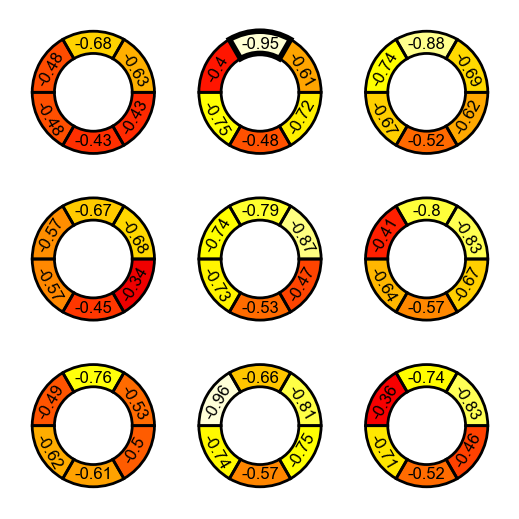

In [56]:
from matplotlib import cm


from matplotlib import cm

sns.set_style("white") 
sns.set_style(style=None, rc=None) 
fig = plt.figure(figsize=(5, 5), layout="constrained",dpi=100)
fig.get_layout_engine().set(wspace=-5, w_pad=-5, hspace=-5, h_pad=-5)
axs = fig.subplots(3, 3, subplot_kw=dict(projection='polar'))
cmap = cm.get_cmap('hot_r')  # Get cividis colormap
norm = mpl.colors.Normalize(vmin=-1, vmax=0)
# Create an empty ScalarMappable to set the colorbar's colormap and norm.
# The following gives a basic continuous colorbar with ticks and labels.

count = 0
for ii in range(3):
    for jj in range(3):
        plot_values = np.concatenate(([np.nan]*6,segment_group_med[count,:]))
        bold = seg_idx[count]
        
        #plot_values = [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,0.5,1,1.5,2,2.5,3,3.5]
        bullseye_plot(axs[ii,jj], plot_values, cmap=cmap, norm=norm,seg_bold = bold,)
        count +=1
        axs[ii,jj].spines['polar'].set_visible(False)
        

fig.savefig('HAP_figure_aha_segments.svg', format='svg', bbox_inches='tight')



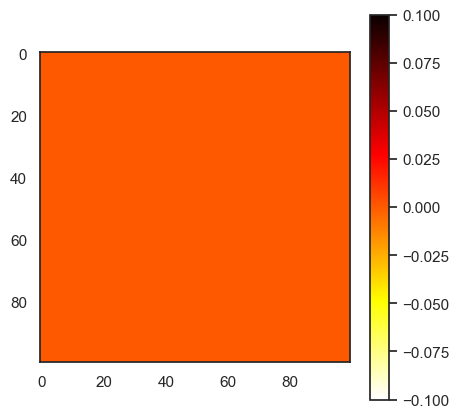

In [57]:
fig = plt.figure(figsize=(5, 5), dpi=100)
plt.imshow(np.zeros((100,100)),cmap = 'hot_r')
plt.colorbar()
fig.savefig('cmap.svg')